In [ ]:
!pip3 install obci_readmanager

In [ ]:
#Importy
import pandas as pd
from obci_readmanager.signal_processing.read_manager import ReadManager
import numpy.fft as fft
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
import scipy.signal as ss
from  scipy.signal import freqz, group_delay #funkcja obliczająca funkcję systemu
from  scipy.signal import firwin, firwin2     # funkcje do projektowania filtrów FIR
from  scipy.signal import butter, buttord     # funkcje do projektowania filtrów  
from  scipy.signal import cheby1, cheb1ord    # funkcje do projektowania filtrów 
from  scipy.signal import cheby2, cheb2ord    # funkcje do projektowania filtrów 
from  scipy.signal import ellip, ellipord     # funkcje do projektowania filtrów eliptycznych
from  scipy.signal import iirnotch
from  scipy.signal import lfilter, filtfilt # funkcje do aplikowania filtrów
from  scipy.signal import butter
import matplotlib.collections as collections

In [ ]:
#Ustawiam domyślne wielkości wykresów
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 100 
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.linestyle": '--', "grid.linewidth": 0.5 })
plt.subplots_adjust(top = 1, bottom = 0.3, wspace=1, hspace=2)

<Figure size 2000x1000 with 0 Axes>

2021-06-01 11:37:49,879 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


['horizontal', 'vertical', 'gnd']
['wahadlo', 'szachownica', 'pasek', 'tekst']


Text(0, 0.5, 'Voltage [uV]')

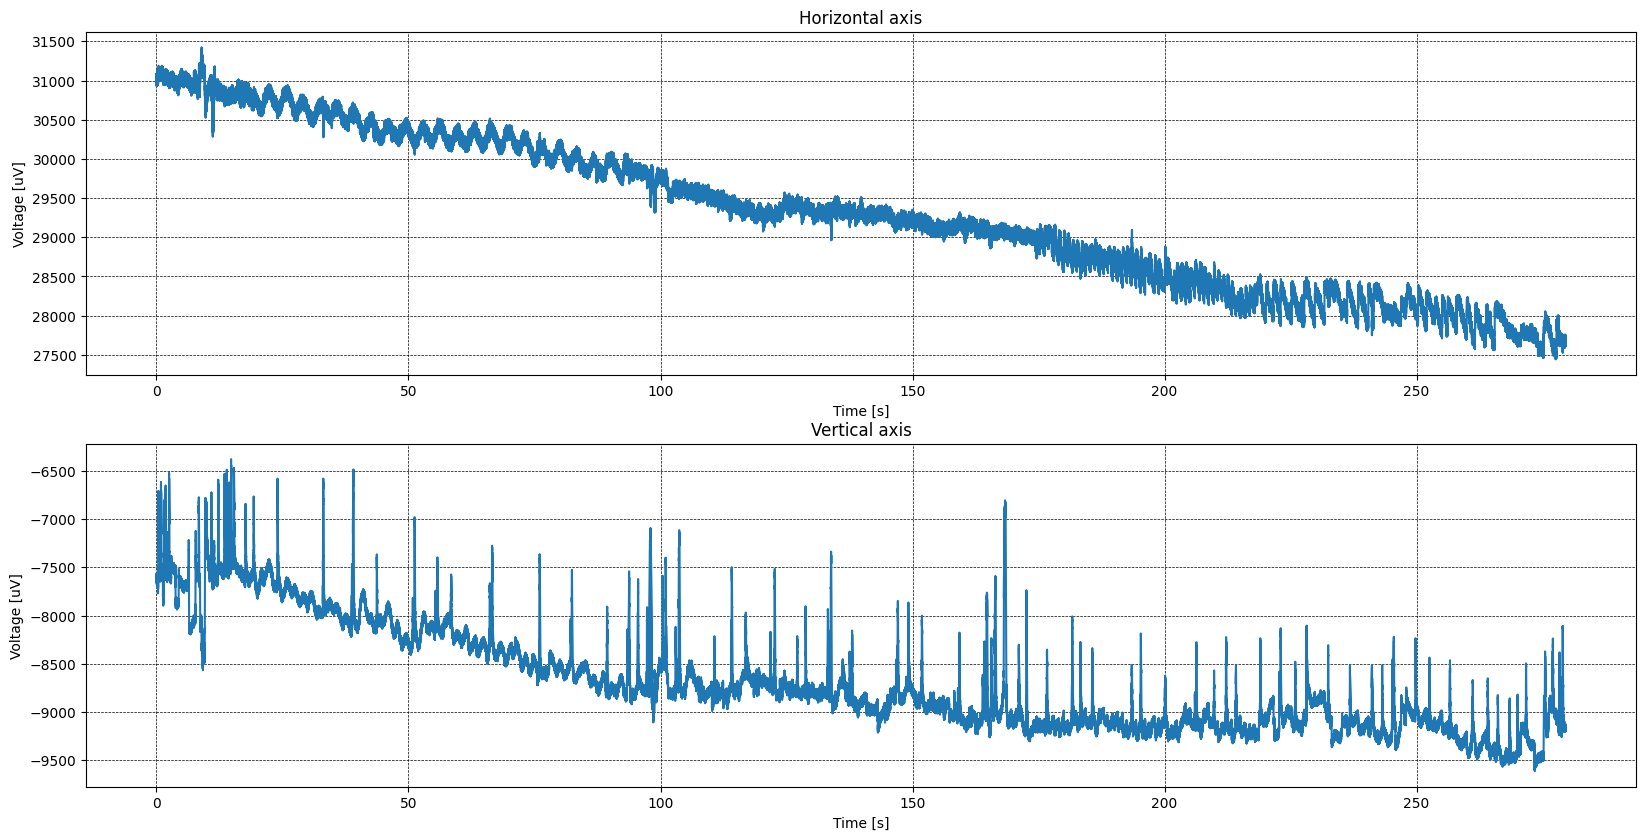

In [ ]:

#emg1 = ReadManager("eog_kwadraty_lukasz.xml", "eog_kwadraty_lukasz.raw", "eog_kwadraty_lukasz.tag")
emg1 = ReadManager("Lukasz_eog.xml", "Lukasz_eog.raw", "Lukasz_eog.tag")

channels_names_1 = emg1.get_param("channels_names")

print(channels_names_1)

# Pobierz cały, wybrany kanał
HORi = emg1.get_channel_samples("horizontal") * 0.0715
VERt = emg1.get_channel_samples("vertical") * 0.0715

#Parametry podstawowe
Fs = 2048
T = len(HORi)/Fs 
dt = 1/Fs
t = np.arange(0,T,dt)
f = np.arange(0.01,Fs/2,0.01)

# Pobierz wszystkie znaczniki
tags = emg1.get_tags()
tagnames = []
for tag in tags:
  if tag['name'] not in tagnames:
    tagnames.append(tag['name'])
print(tagnames)

#Plotuję surowe sygnały
plt.subplot(2,1,1)
plt.plot(t,HORi)
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.subplot(2,1,2)
plt.plot(t,VERt)
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')

Text(0, 0.5, 'Voltage [uV]')

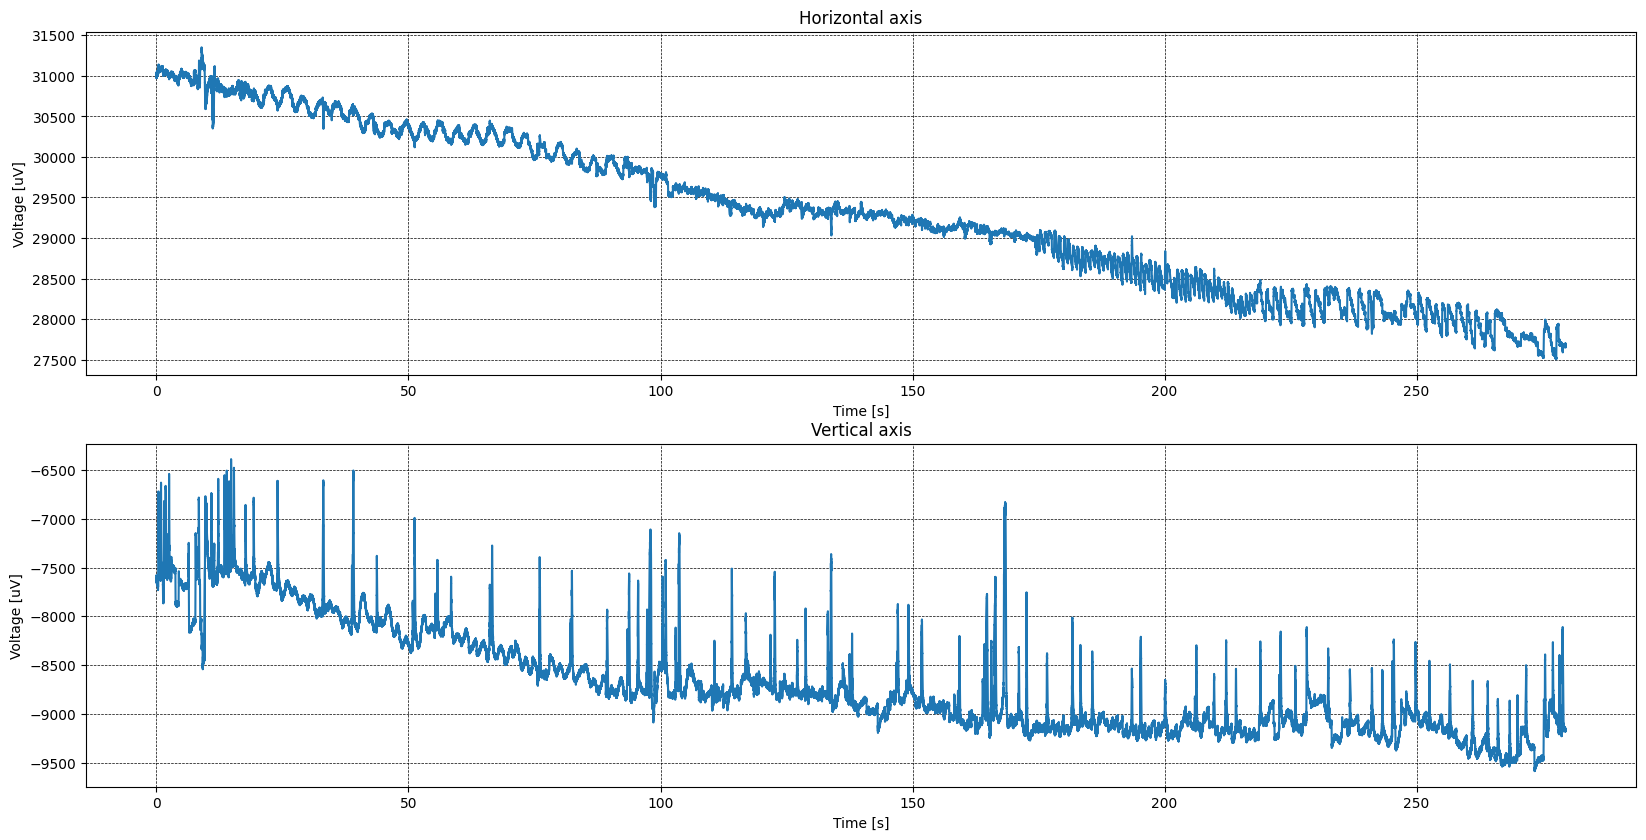

In [ ]:
sigs = [HORi, VERt]

def notchFilter(sigs:list, Fs: int) -> list:
  filtered_channels = []
  for channel in sigs:
    [b,a] = cheby2(2, rs = 25, Wn = (49,51) , btype='bandstop', analog=0, output='ba', fs=Fs)
    sf = filtfilt(b, a, channel) #Notch
    filtered_channels.append(sf)
  return filtered_channels

HOR, VER = notchFilter(sigs, Fs=Fs)

plt.subplot(2,1,1)
plt.plot(t,HOR)
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.subplot(2,1,2)
plt.plot(t,VER)
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')

In [ ]:
WTags = np.zeros(len(t))
STags = np.zeros(len(t))
PTags = np.zeros(len(t))
TTags = np.zeros(len(t))

wtp = []
stp = []
ptp = []
ttp = []

for item in tags:
  if item['name'] == 'wahadlo':
    idx0 =  int(item['start_timestamp']*Fs)
    idx1 =  int(item['end_timestamp']*Fs)
    WTags[idx0:idx1] = 1
    wtp.append((idx0,idx1))
  if item['name'] == 'szachownica':
    idx0 =  int(item['start_timestamp']*Fs)
    idx1 =  int(item['end_timestamp']*Fs)
    STags[idx0:idx1] = 1
    stp.append((idx0,idx1))
  if item['name'] == 'pasek':
    idx0 =  int(item['start_timestamp']*Fs)
    idx1 =  int(item['end_timestamp']*Fs)
    PTags[idx0:idx1] = 1
    ptp.append((idx0,idx1))
  if item['name'] == 'tekst':
    idx0 =  int(item['start_timestamp']*Fs)
    idx1 =  int(item['end_timestamp']*Fs)
    TTags[idx0:idx1] = 1
    ttp.append((idx0,idx1))

Text(0, 0.5, 'Voltage [uV]')

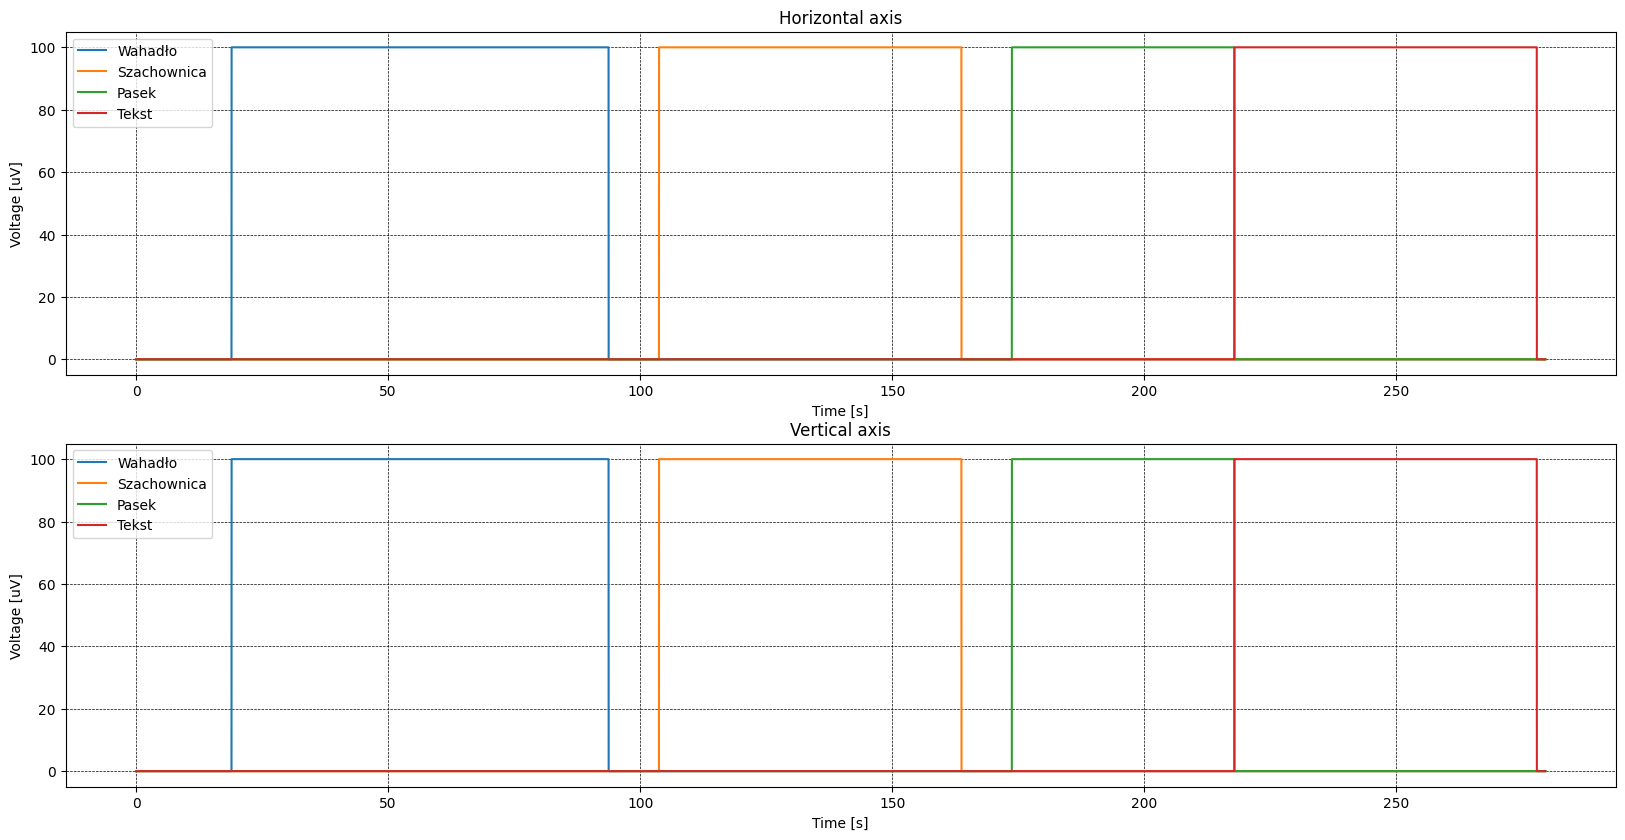

In [ ]:
plt.subplot(2,1,1)
#plt.plot(t,HOR)
plt.plot(t,WTags*100, label = 'Wahadło')
plt.plot(t,STags*100, label = 'Szachownica')
plt.plot(t,PTags*100, label = 'Pasek')
plt.plot(t,TTags*100, label = 'Tekst')
plt.legend()
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.subplot(2,1,2)
#plt.plot(t,VER)
plt.plot(t,WTags*100, label = 'Wahadło')
plt.plot(t,STags*100, label = 'Szachownica')
plt.plot(t,PTags*100, label = 'Pasek')
plt.plot(t,TTags*100, label = 'Tekst')
plt.legend()
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')

In [ ]:
def compareHighOrLowFilters(sigs: list, cutoffs: list, Fs: int, start: int, end: int, filterType: str) -> list:
  filtered_channels = []
  i = len(sigs)
  #plt.figure(tight_layout = True)
  for channel in sigs:
    for cutoff in cutoffs:
      n = len(cutoffs)*len(sigs) - (len(cutoffs)*i) + cutoffs.index(cutoff) + 1
      if cutoffs.index(cutoff) == 0:
        t = np.arange(0,len(channel)/Fs ,1/Fs)
        [b,a] = butter(1,cutoff,fs=Fs,btype=filterType)
        sf = filtfilt(b, a, channel)
        plt.subplot(len(cutoffs)*len(sigs), 1, n)
        plt.plot(t[start*Fs:end*Fs],sf[start*Fs:end*Fs])
        plt.title('Cutoff freq:'+str(cutoff))
        plt.xlabel('Time [s]')
        plt.ylabel('Voltage [uV]')
      else:
        t = np.arange(0,len(channel)/Fs ,1/Fs)
        [b,a] = butter(1,cutoff,fs=Fs,btype=filterType)
        sf = filtfilt(b, a, sf)
        plt.subplot(len(cutoffs)*len(sigs), 1, n)
        plt.plot(t[start*Fs:end*Fs],sf[start*Fs:end*Fs])
        plt.title('Cutoff freq:'+str(cutoff))
        plt.xlabel('Time [s]')
        plt.ylabel('Voltage [uV]')
    i -= 1
    filtered_channels.append(sf)
  return filtered_channels

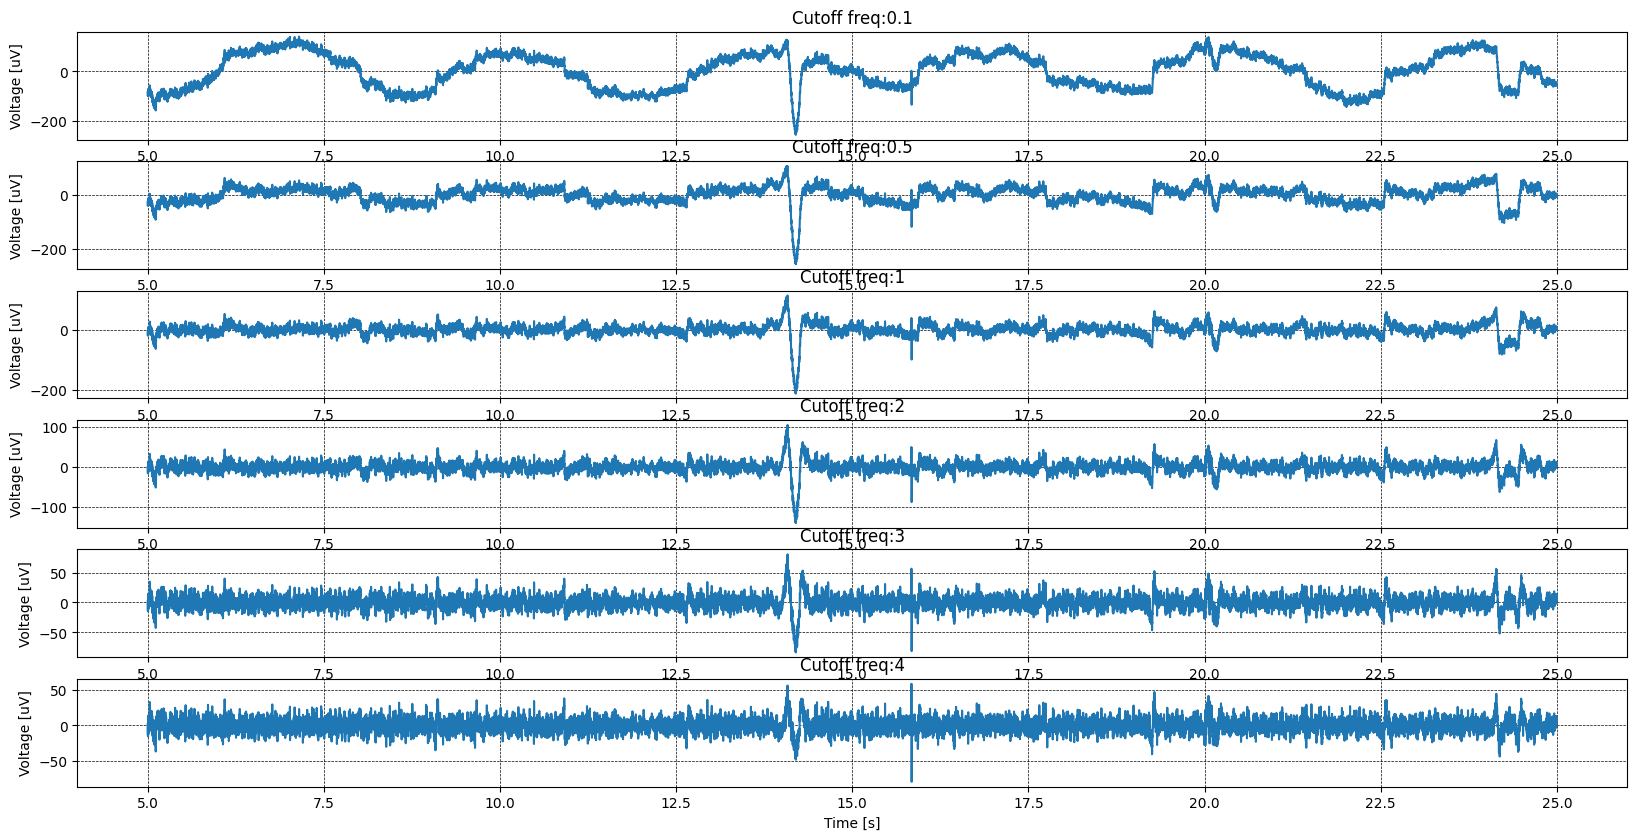

In [ ]:
HFw = compareHighOrLowFilters([HOR[wtp[0][0]:wtp[0][1]]], [0.1, 0.5, 1, 2, 3, 4], Fs, 5, 25, 'highpass')

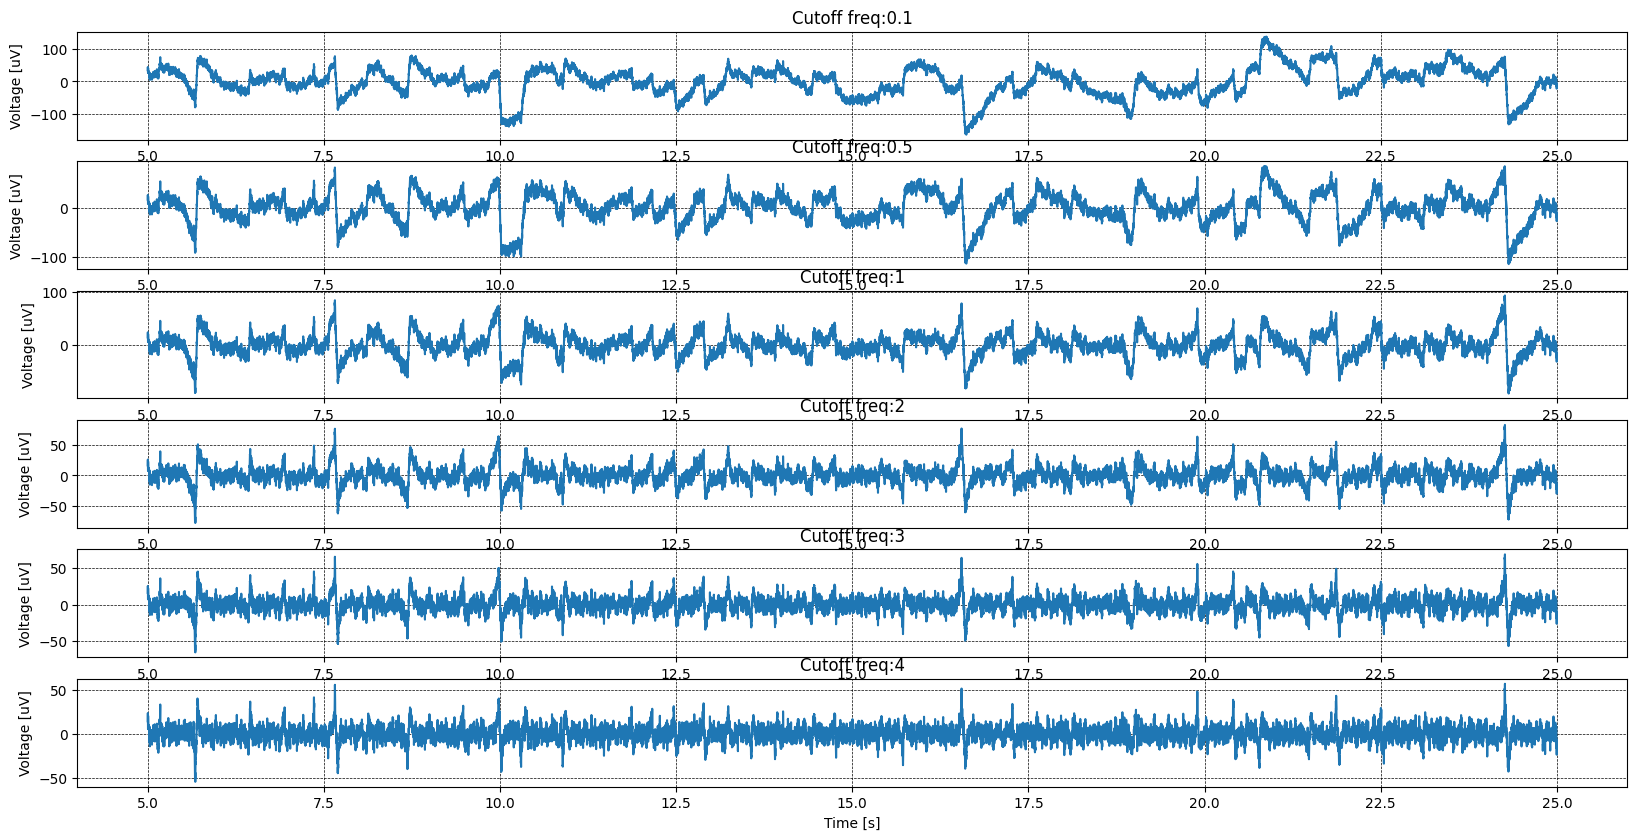

In [ ]:
HFs = compareHighOrLowFilters([HOR[stp[0][0]:stp[0][1]]], [0.1, 0.5, 1, 2, 3, 4], Fs, 5, 25, 'highpass')

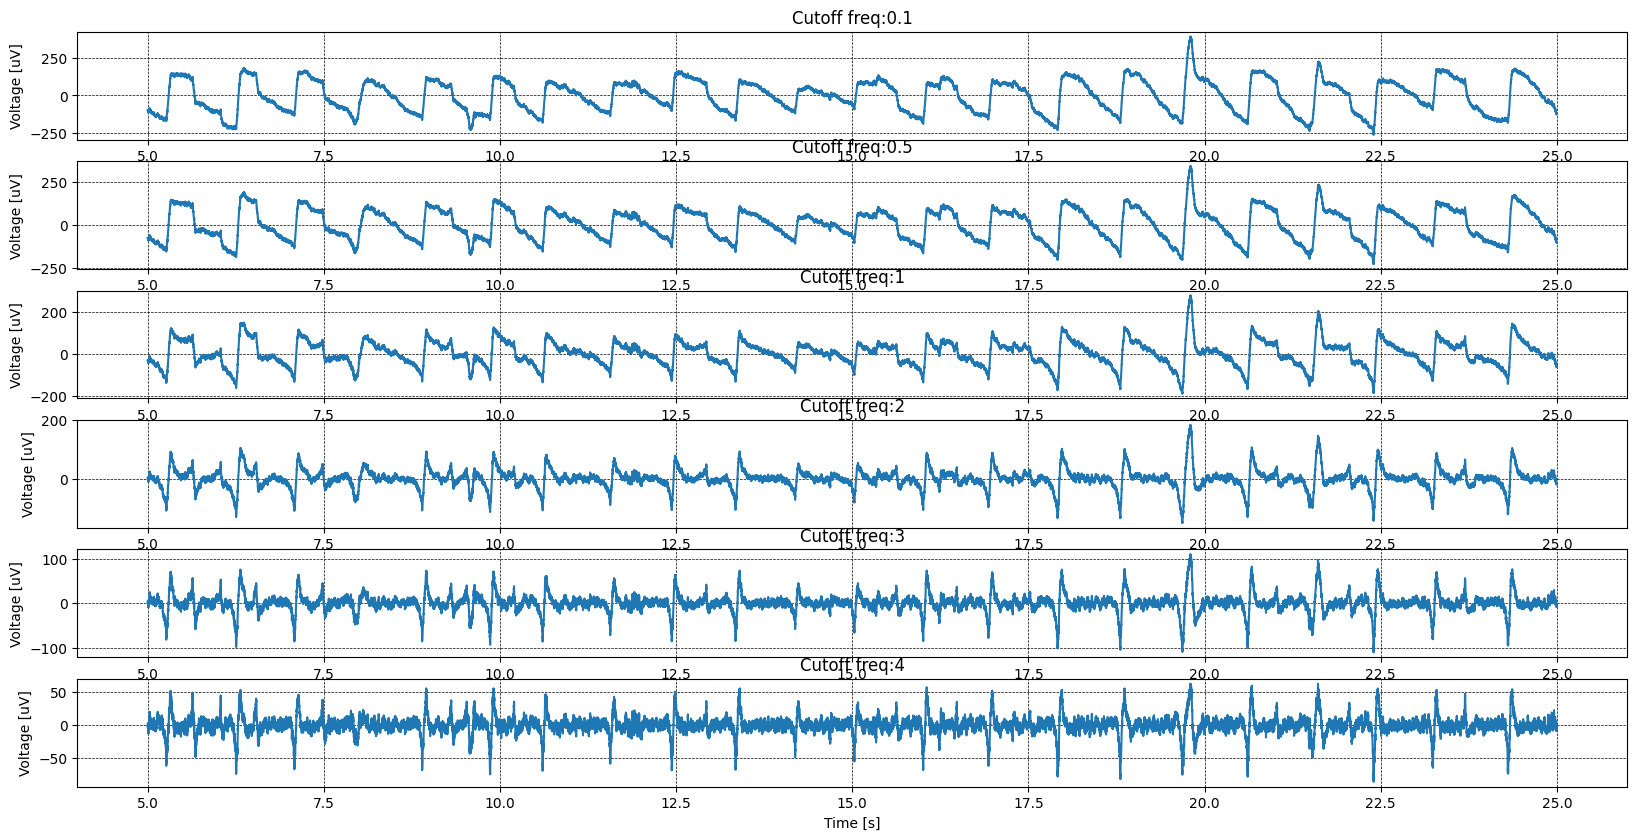

In [ ]:
HFp = compareHighOrLowFilters([HOR[ptp[0][0]:ptp[0][1]]], [0.1, 0.5, 1, 2, 3, 4], Fs, 5, 25, 'highpass')

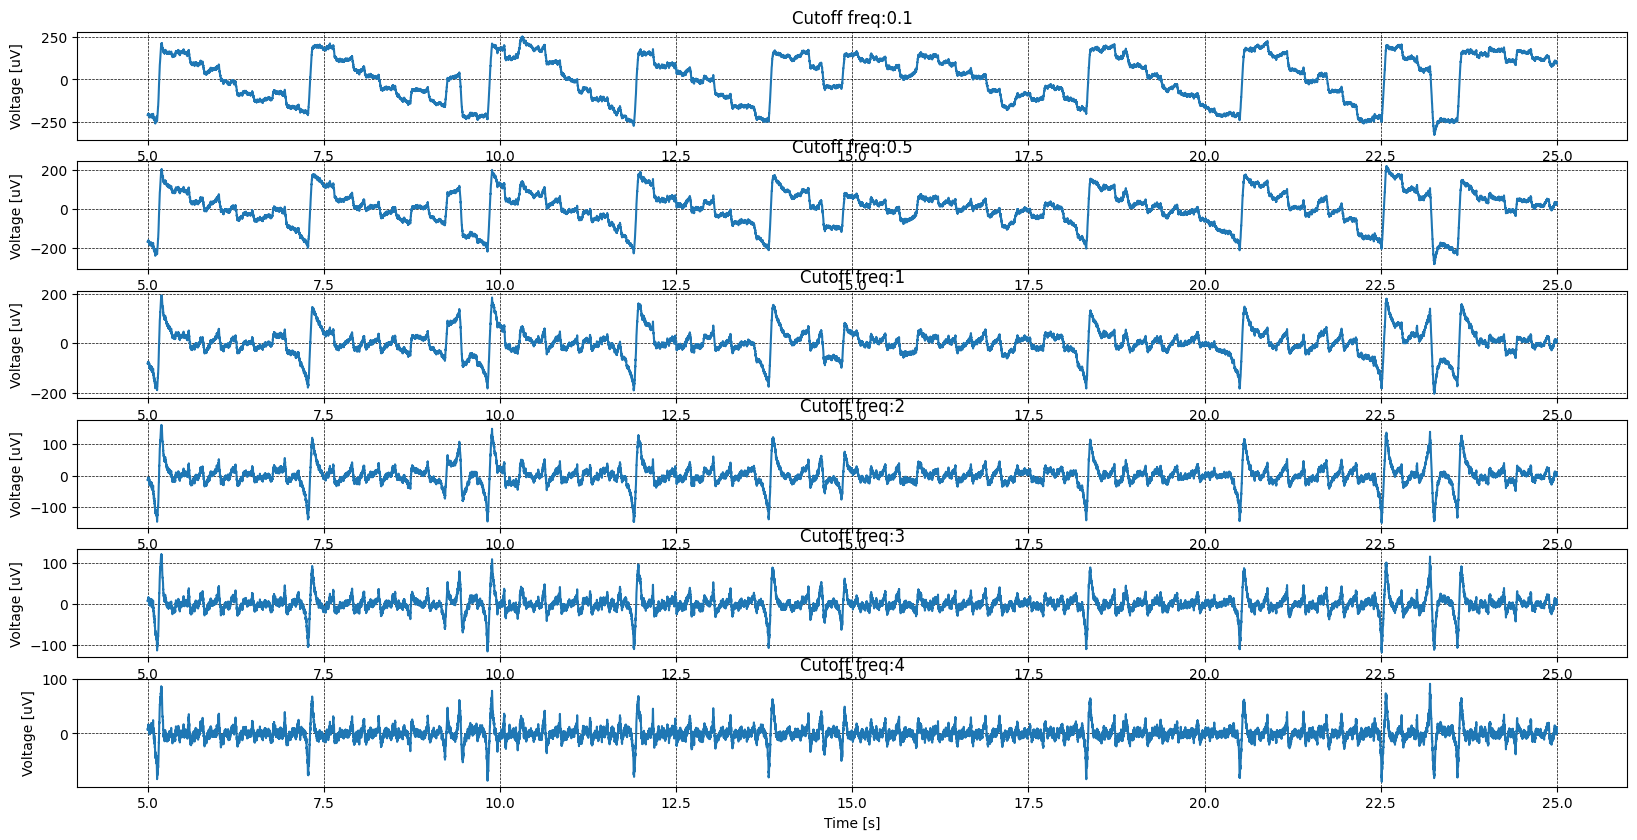

In [ ]:
HFt = compareHighOrLowFilters([HOR[ttp[0][0]:ttp[0][1]]], [0.1, 0.5, 1, 2, 3, 4], Fs, 5, 25, 'highpass')

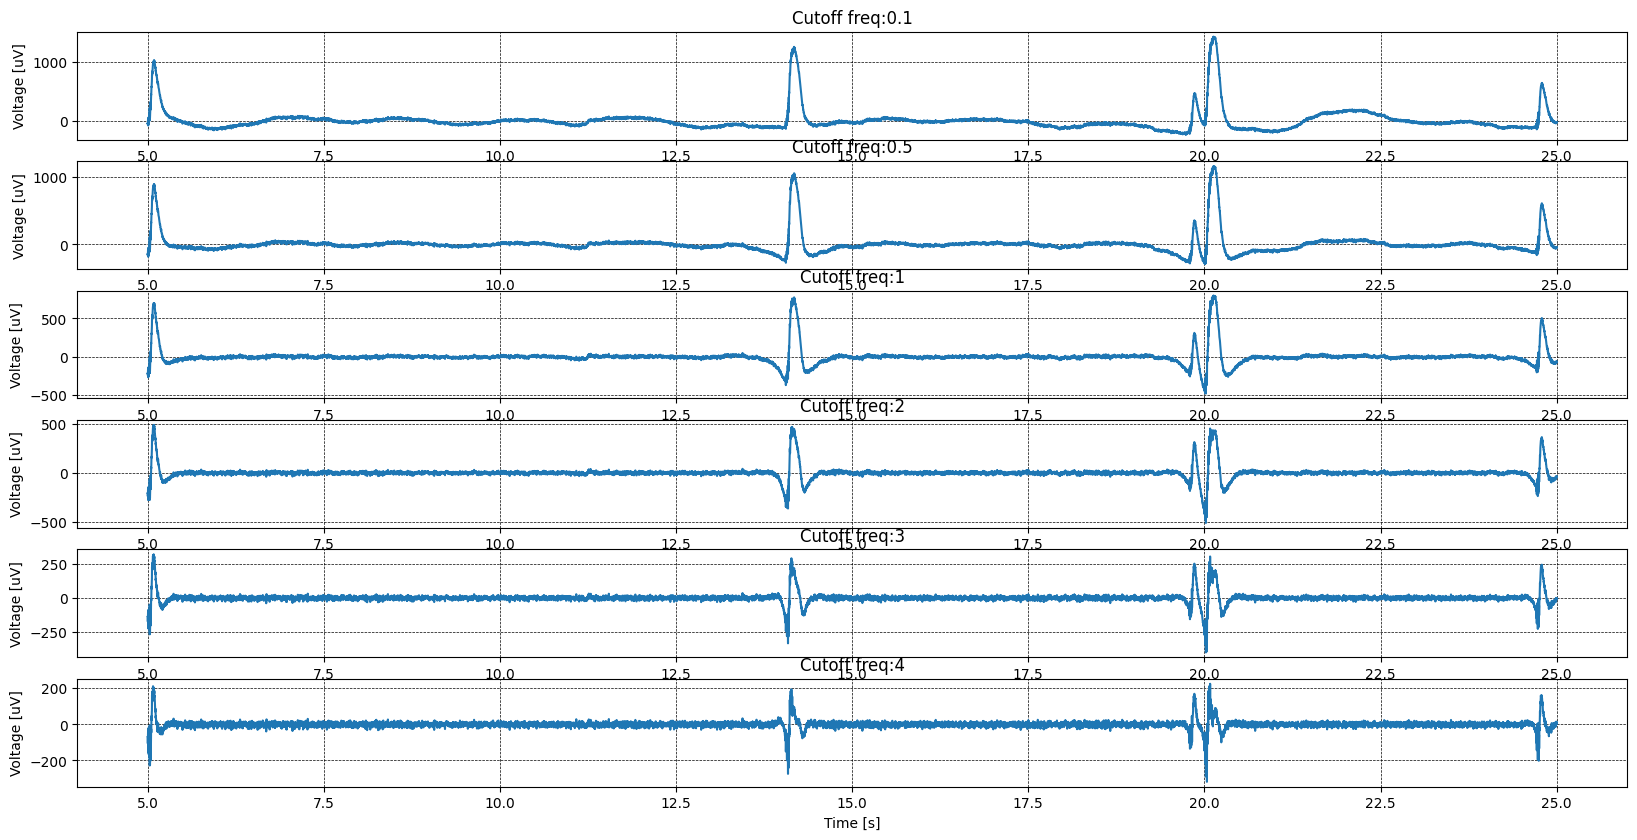

In [ ]:
VFw = compareHighOrLowFilters([VER[wtp[0][0]:wtp[0][1]]], [0.1, 0.5, 1, 2, 3, 4], Fs, 5, 25, 'highpass')

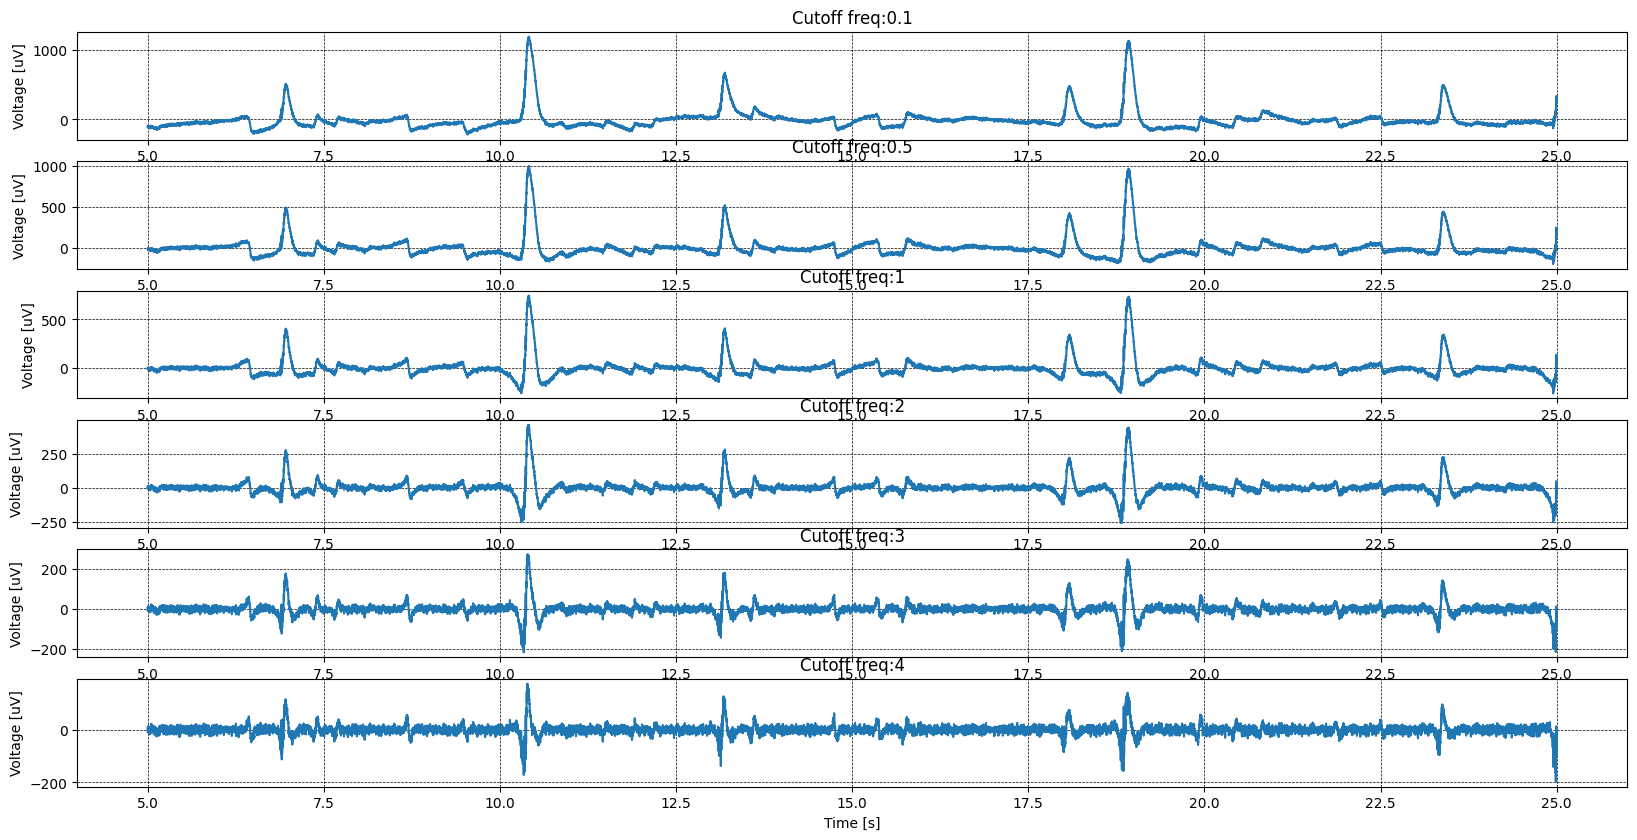

In [ ]:
VFs = compareHighOrLowFilters([VER[stp[0][0]:stp[0][1]]], [0.1, 0.5, 1, 2, 3, 4], Fs, 5, 25, 'highpass')

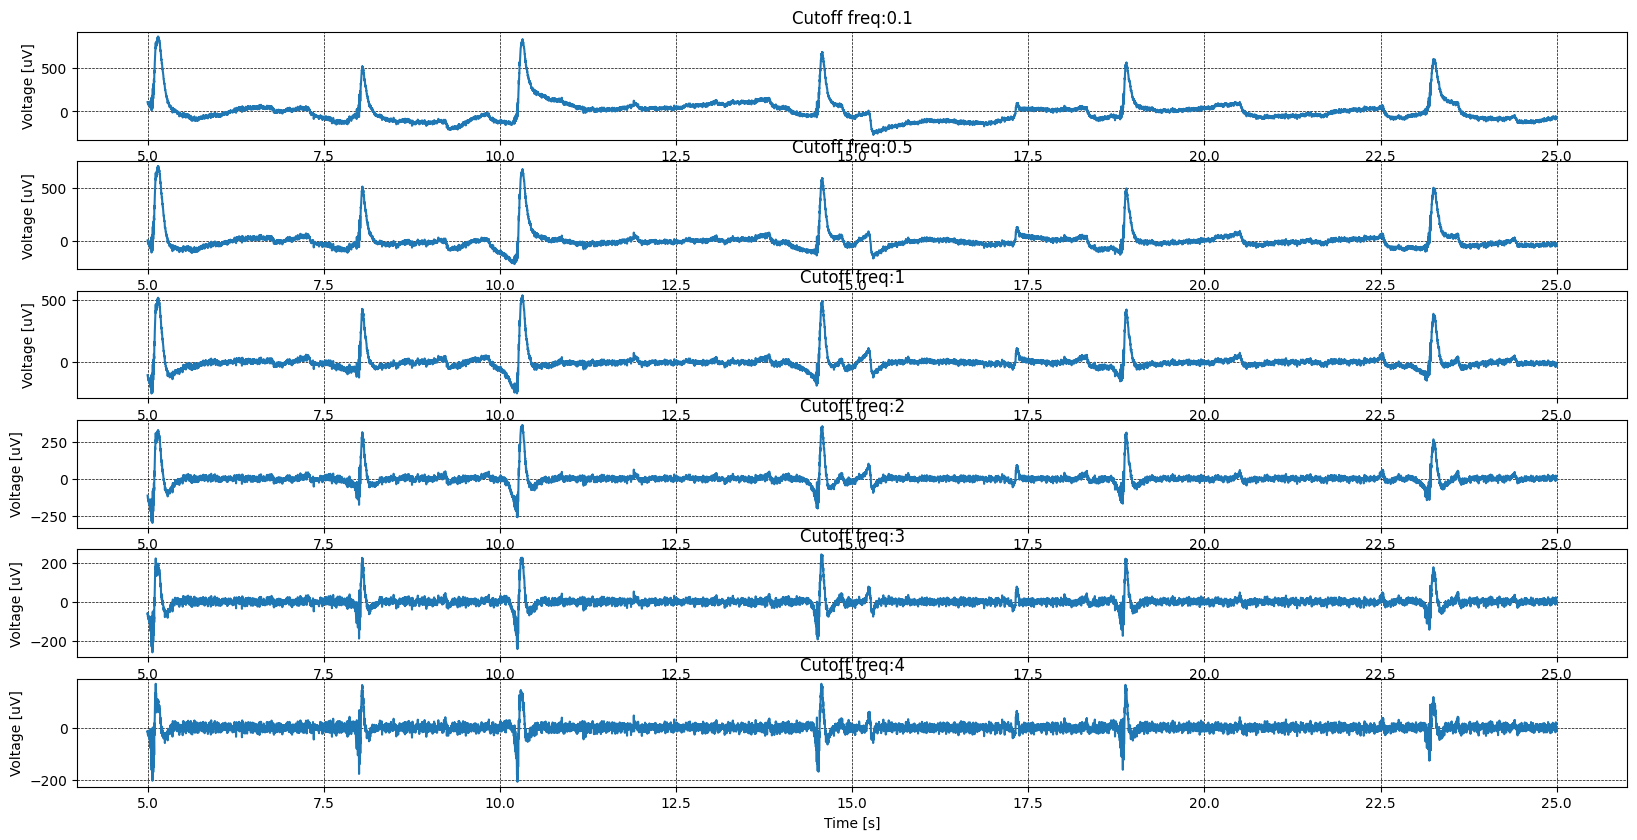

In [ ]:
VFt = compareHighOrLowFilters([VER[ttp[0][0]:ttp[0][1]]], [0.1, 0.5, 1, 2, 3, 4], Fs, 5, 25, 'highpass')

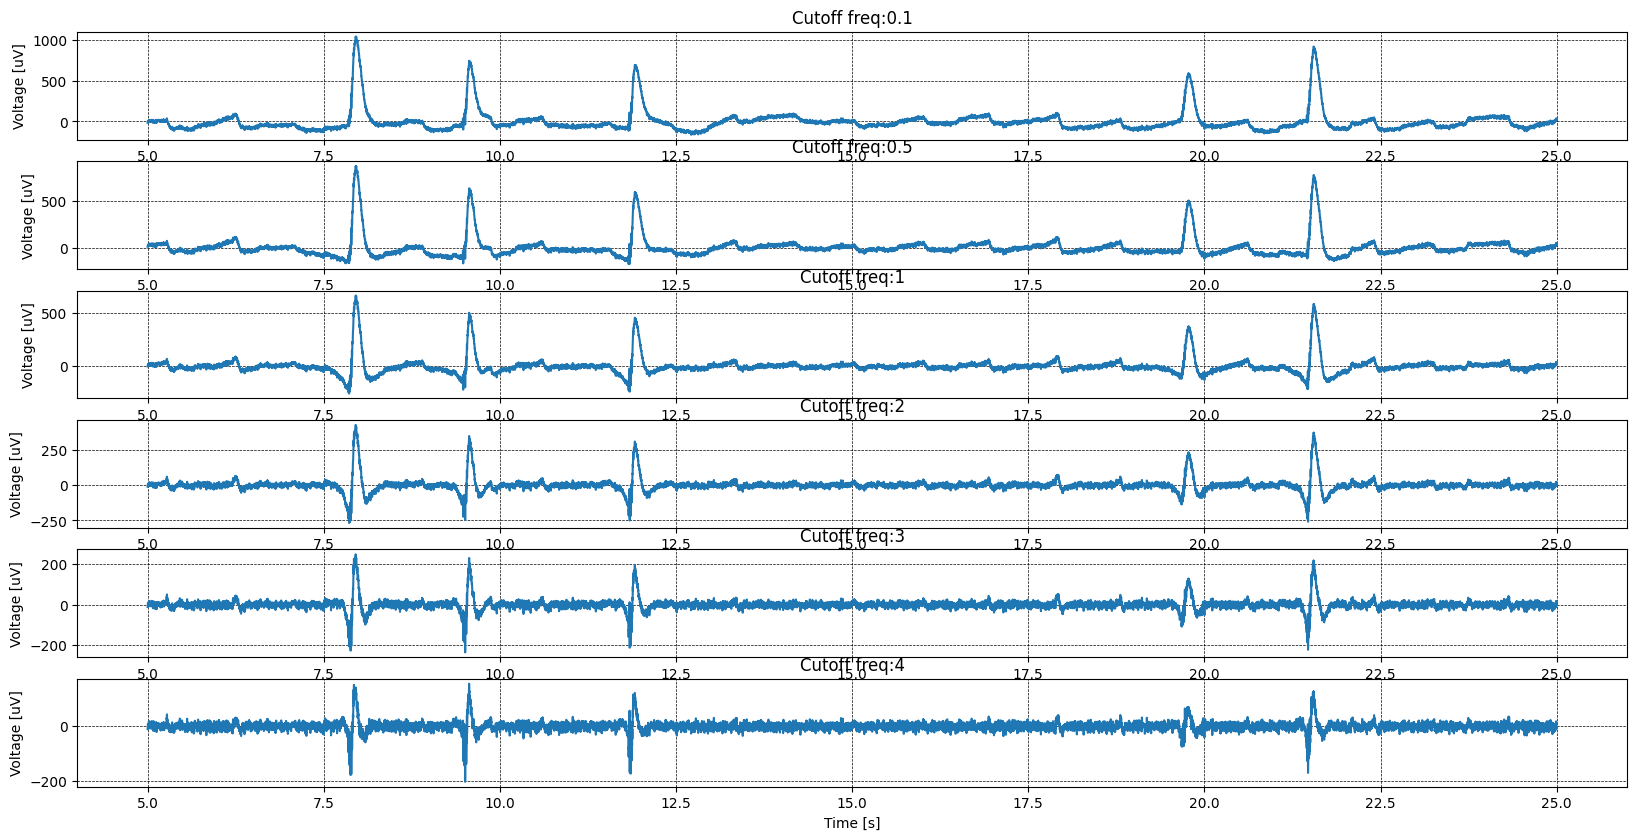

In [ ]:
VFp = compareHighOrLowFilters([VER[ptp[0][0]:ptp[0][1]]], [0.1, 0.5, 1, 2, 3, 4], Fs, 5, 25, 'highpass')

pociąć ten sygnał na 4 zgodnie z eksperymentami - i sprawdzic czy da się je tak filtrowac by byly identyczne - pociac wg czasu lub tagow - dla kazdego fragmentu zrobić te filtry oddzielnie i znalezc optymalny - maja byc 4 porownania i dla calego 

notch zostaje

dodać low pass 15 i 30 tak samo

zdecydować jak należy filtrować sygnał i wczytać tagi z oznaczeniami

dodac applety 

ogarnac fig by bylo estetyczne i lepiej szlo wizualne porownanie

wymysl premium metody na prezentację i obróbkę wyników tym razem

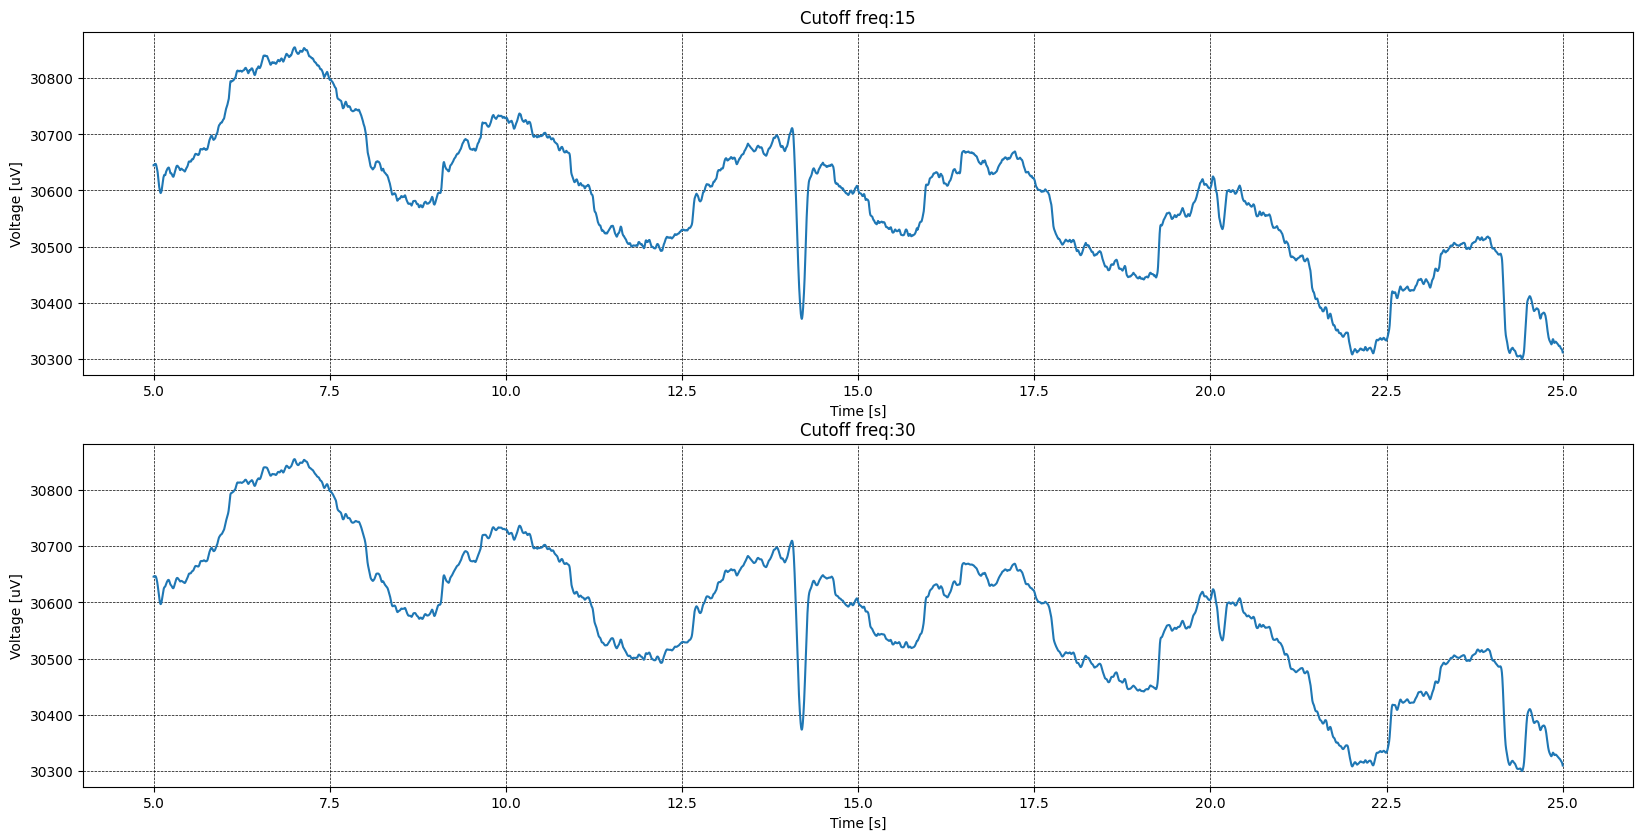

In [ ]:
HFw = compareHighOrLowFilters([HOR[wtp[0][0]:wtp[0][1]]], [15, 30], Fs, 5, 25, 'lowpass')

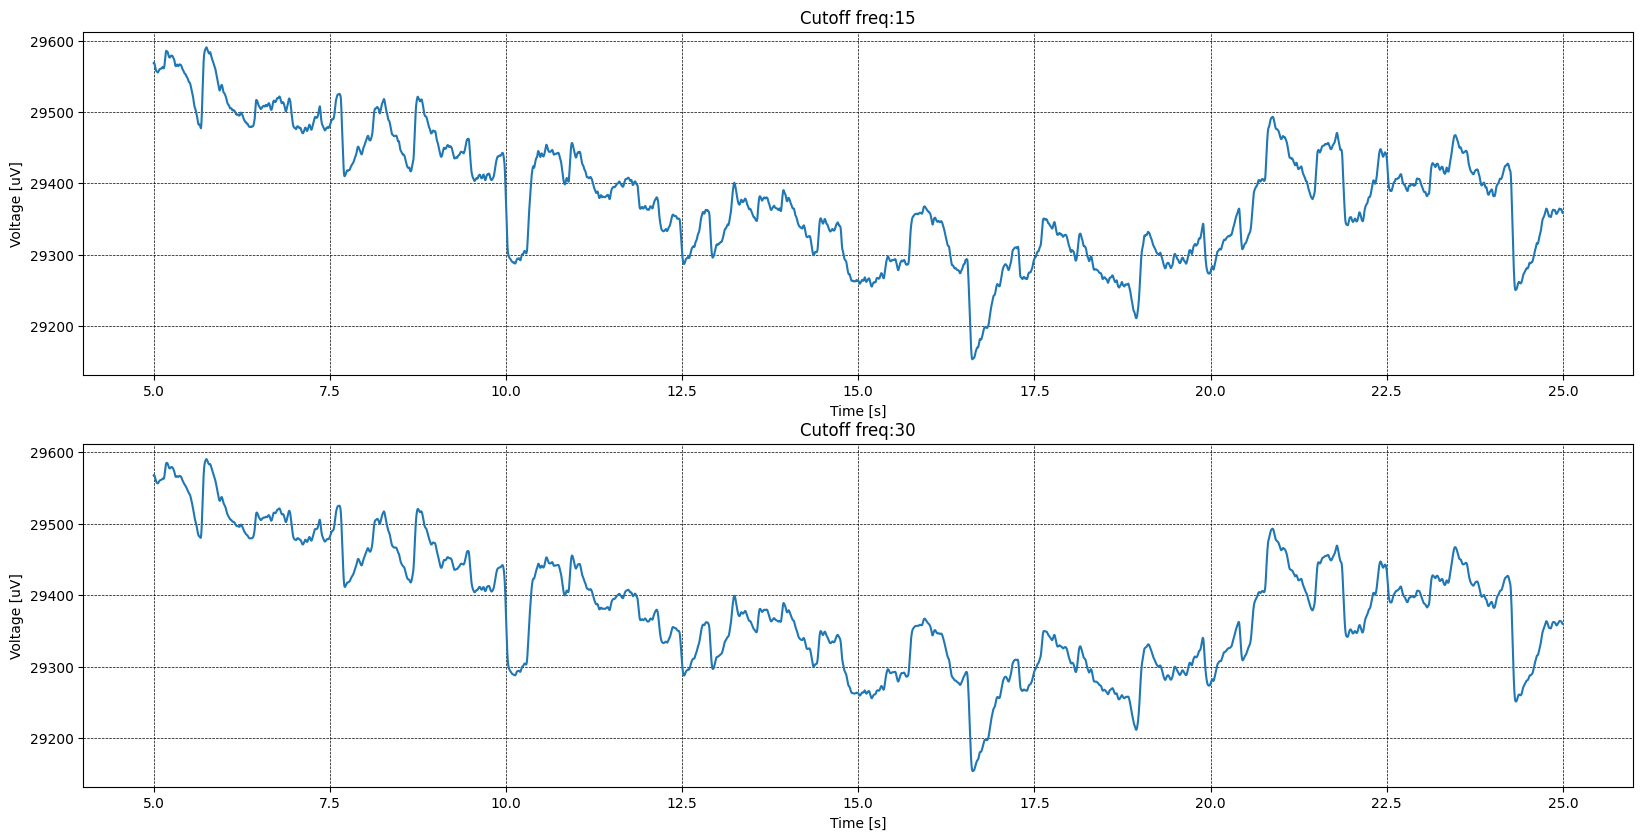

In [ ]:
HFs = compareHighOrLowFilters([HOR[stp[0][0]:stp[0][1]]], [15, 30], Fs, 5, 25, 'lowpass')

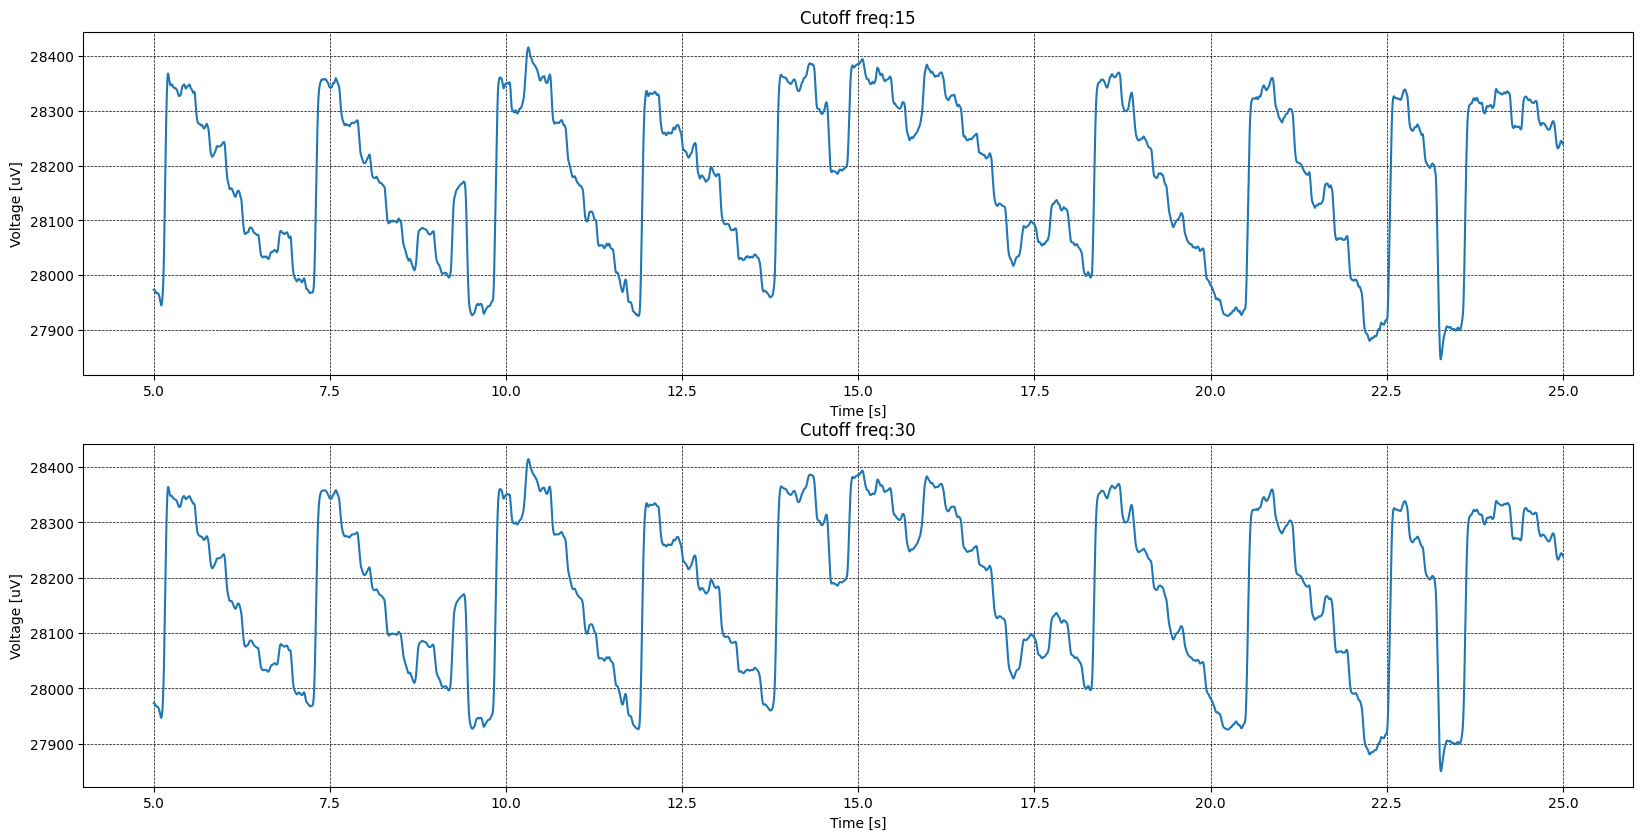

In [ ]:
HFt = compareHighOrLowFilters([HOR[ttp[0][0]:ttp[0][1]]], [15, 30], Fs, 5, 25, 'lowpass')

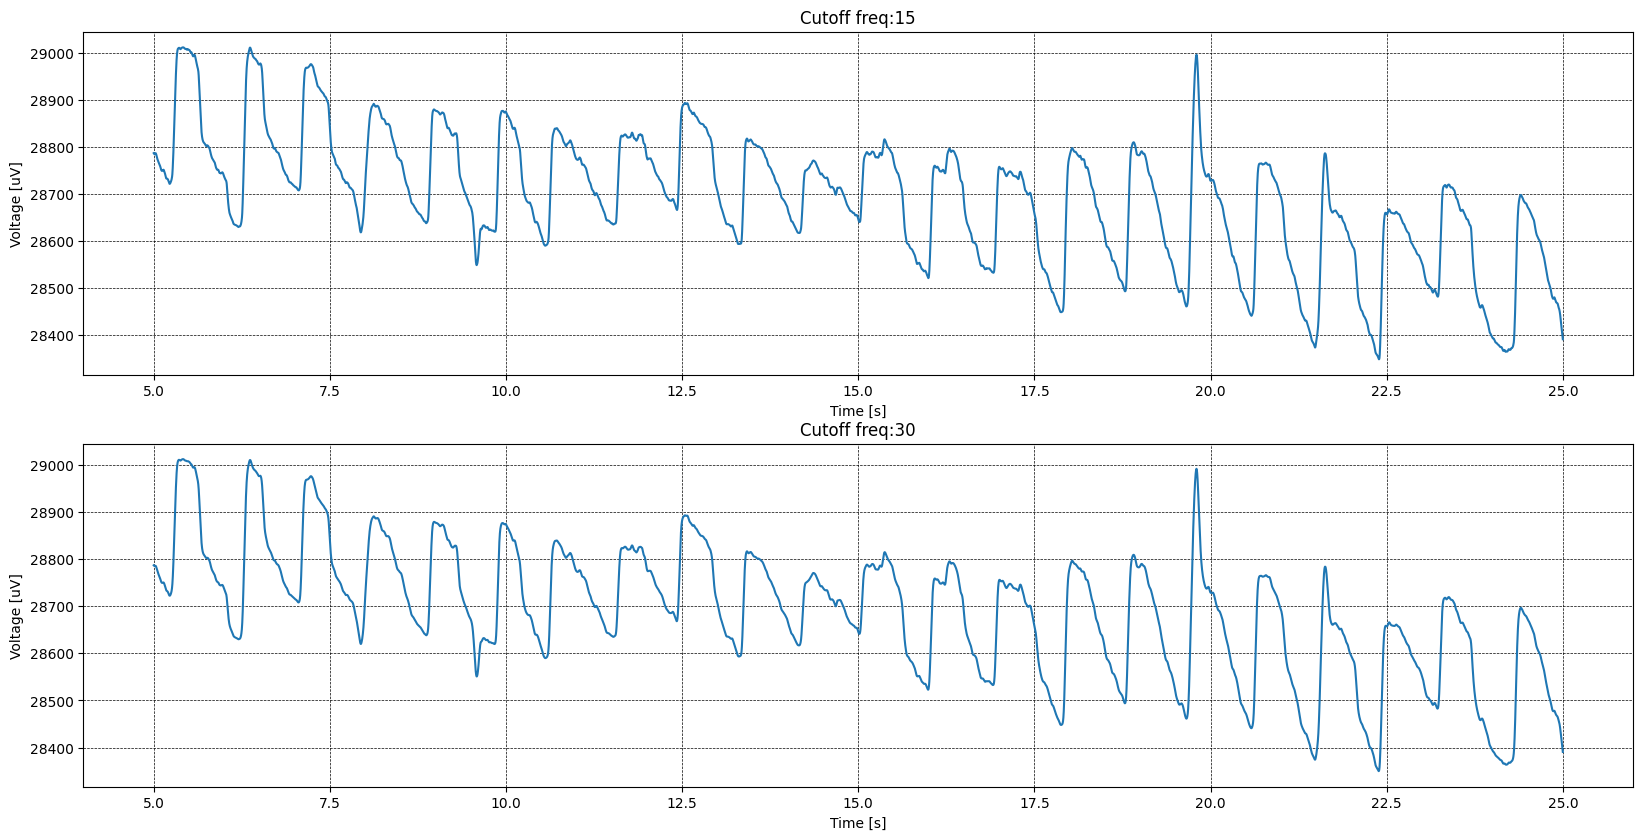

In [ ]:
HFp = compareHighOrLowFilters([HOR[ptp[0][0]:ptp[0][1]]], [15, 30], Fs, 5, 25, 'lowpass')

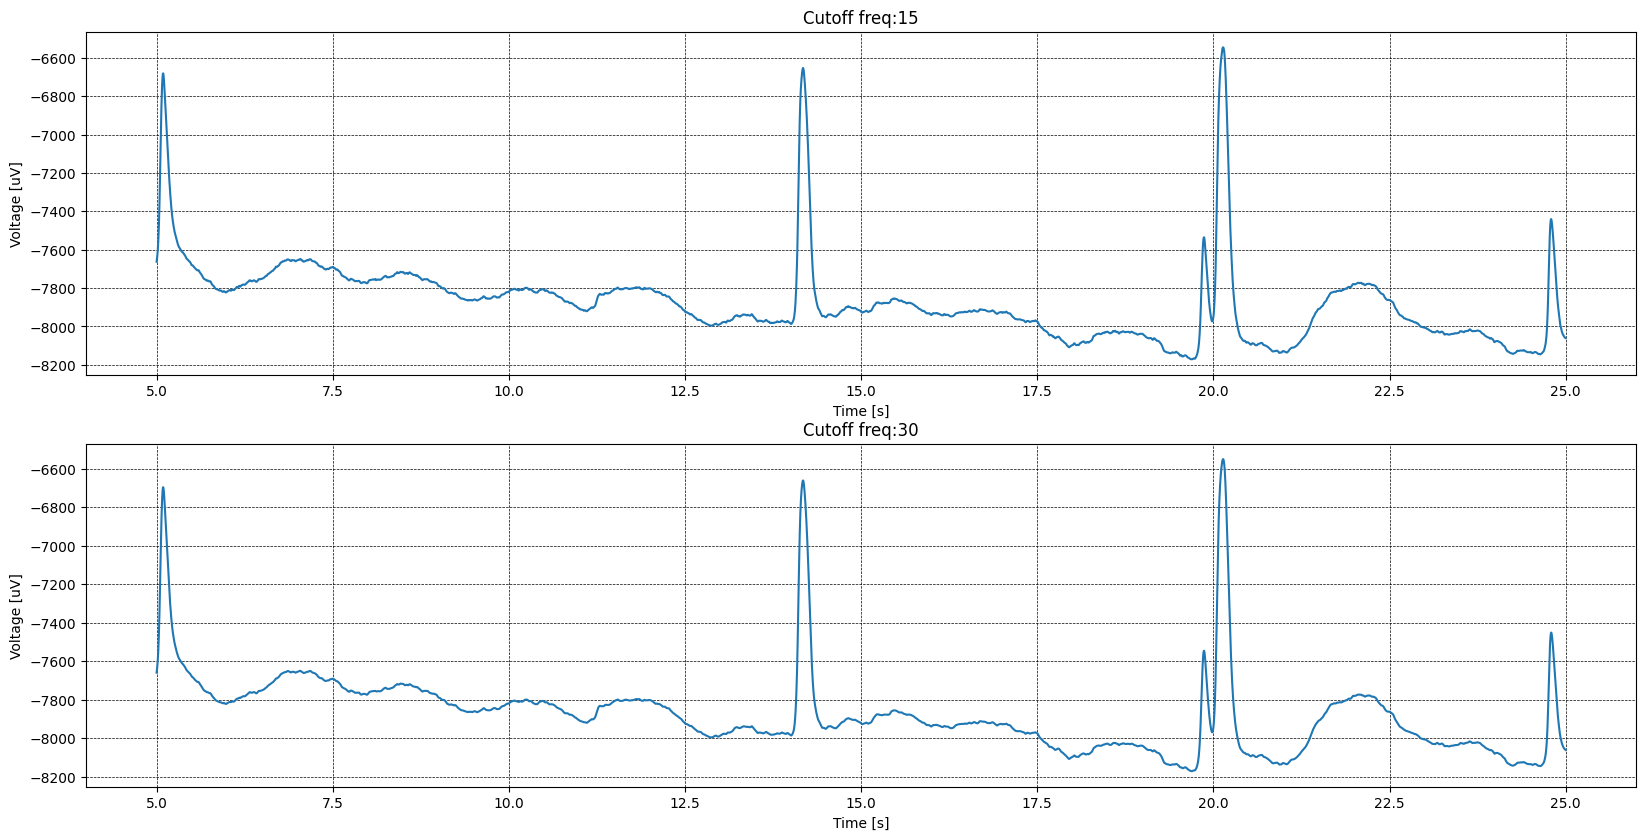

In [ ]:
VFw = compareHighOrLowFilters([VER[wtp[0][0]:wtp[0][1]]], [15, 30], Fs, 5, 25, 'lowpass')

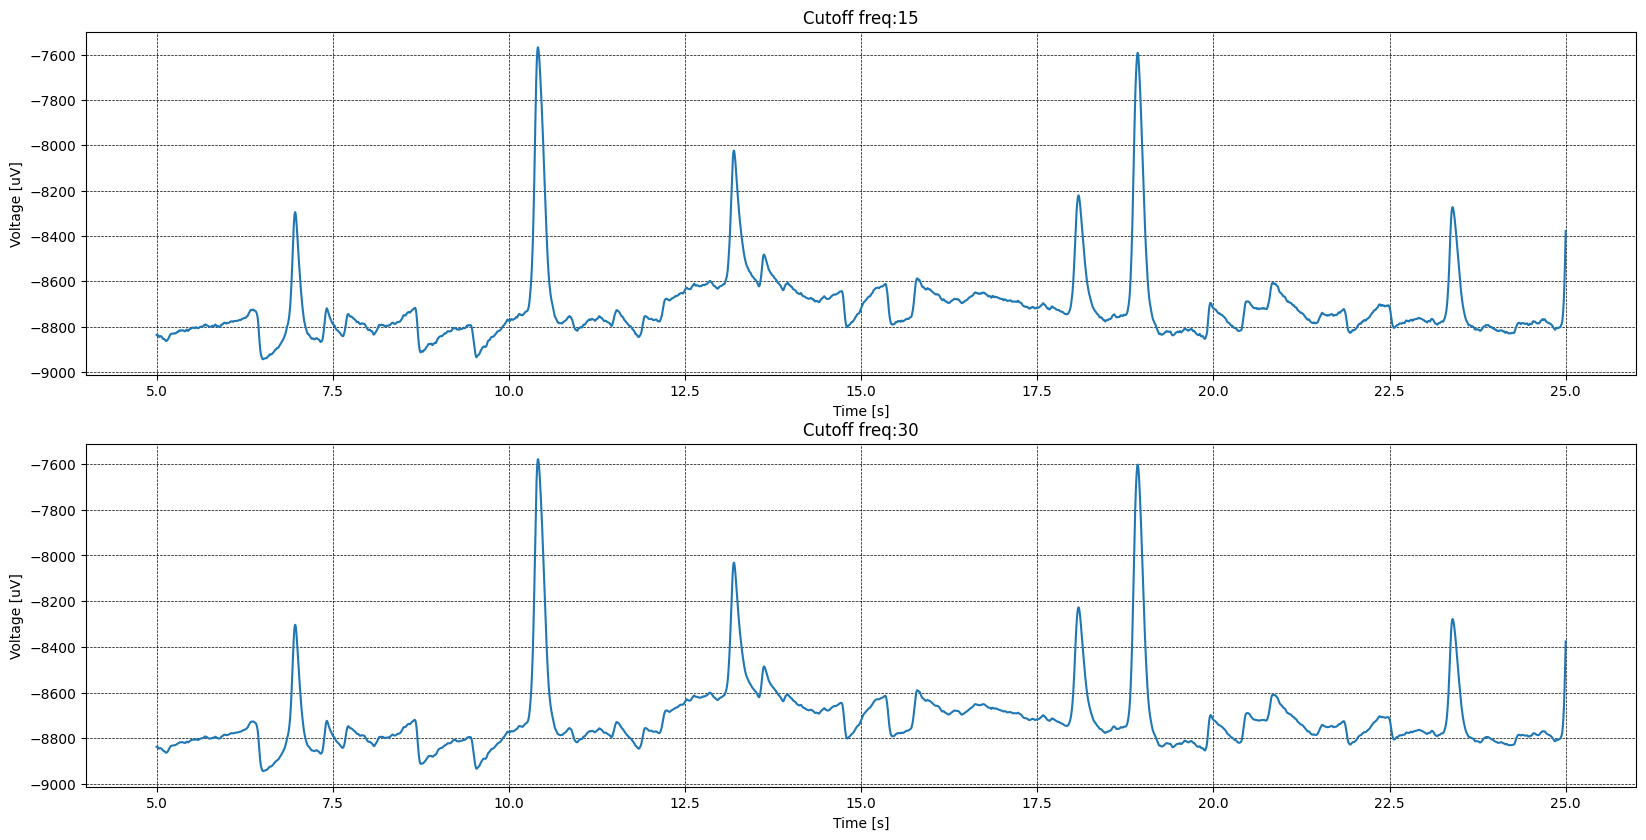

In [ ]:
VFs = compareHighOrLowFilters([VER[stp[0][0]:stp[0][1]]], [15, 30], Fs, 5, 25, 'lowpass')

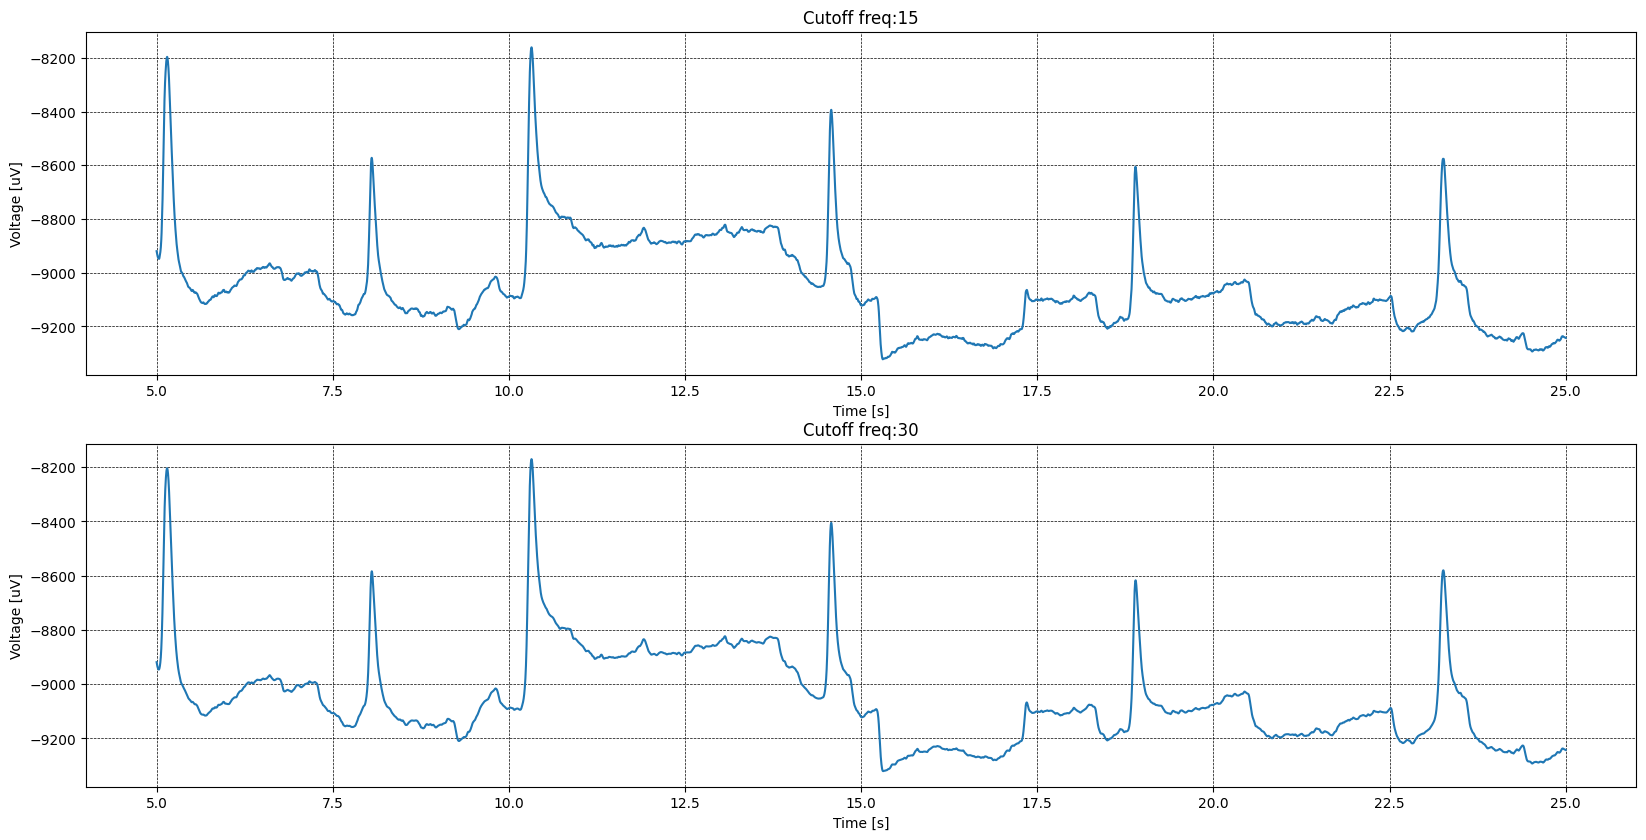

In [ ]:
VFt = compareHighOrLowFilters([VER[ttp[0][0]:ttp[0][1]]], [15, 30], Fs, 5, 25, 'lowpass')

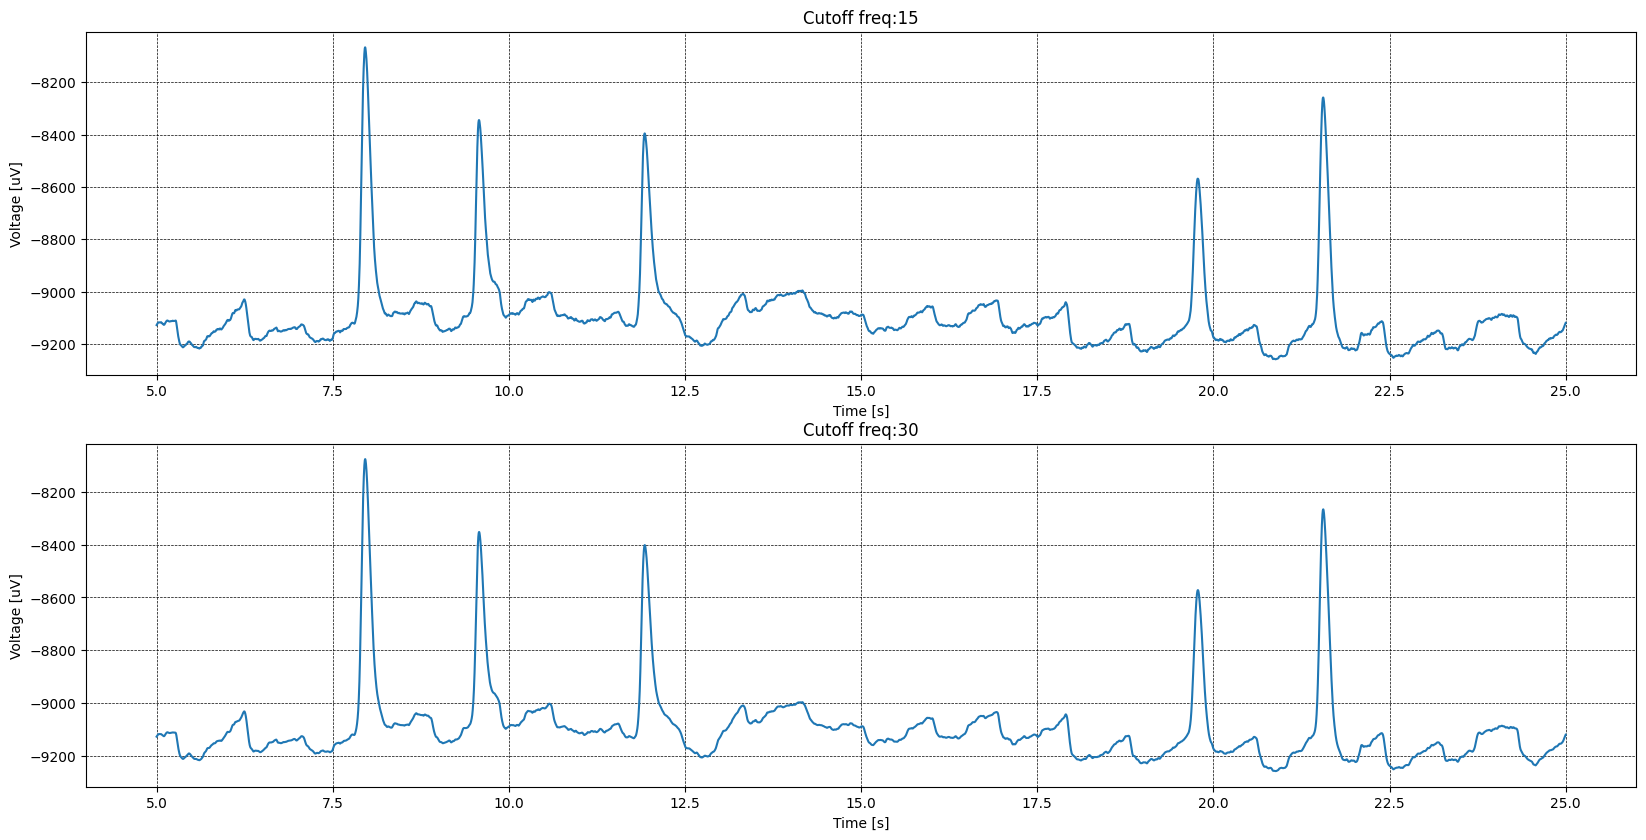

In [ ]:
VFp = compareHighOrLowFilters([VER[ptp[0][0]:ptp[0][1]]], [15, 30], Fs, 5, 25, 'lowpass')

In [ ]:
def filtry(sigs:list=[]) -> list:
  filtered_channels = []
  for channel in sigs:
    [b1,a1]=butter(1,0.5,fs=Fs,btype='highpass')
    sf1 = filtfilt(b1, a1, channel)
    [b2,a2] = cheby2(2, rs = 25, Wn = (49,51) , btype='bandstop', analog=0, output='ba', fs=Fs)
    sf2 = filtfilt(b2, a2, sf1) #Notch
    [b3,a3]=butter(1,15,fs=Fs,btype='lowpass')
    sf3 = filtfilt(b3, a3, sf2)
    #sf3 = sf3**2
    filtered_channels.append(sf3)
  return filtered_channels

filteredH, filteredV = filtry([HORi, VERt])

Text(0, 0.5, 'Voltage [uV]')

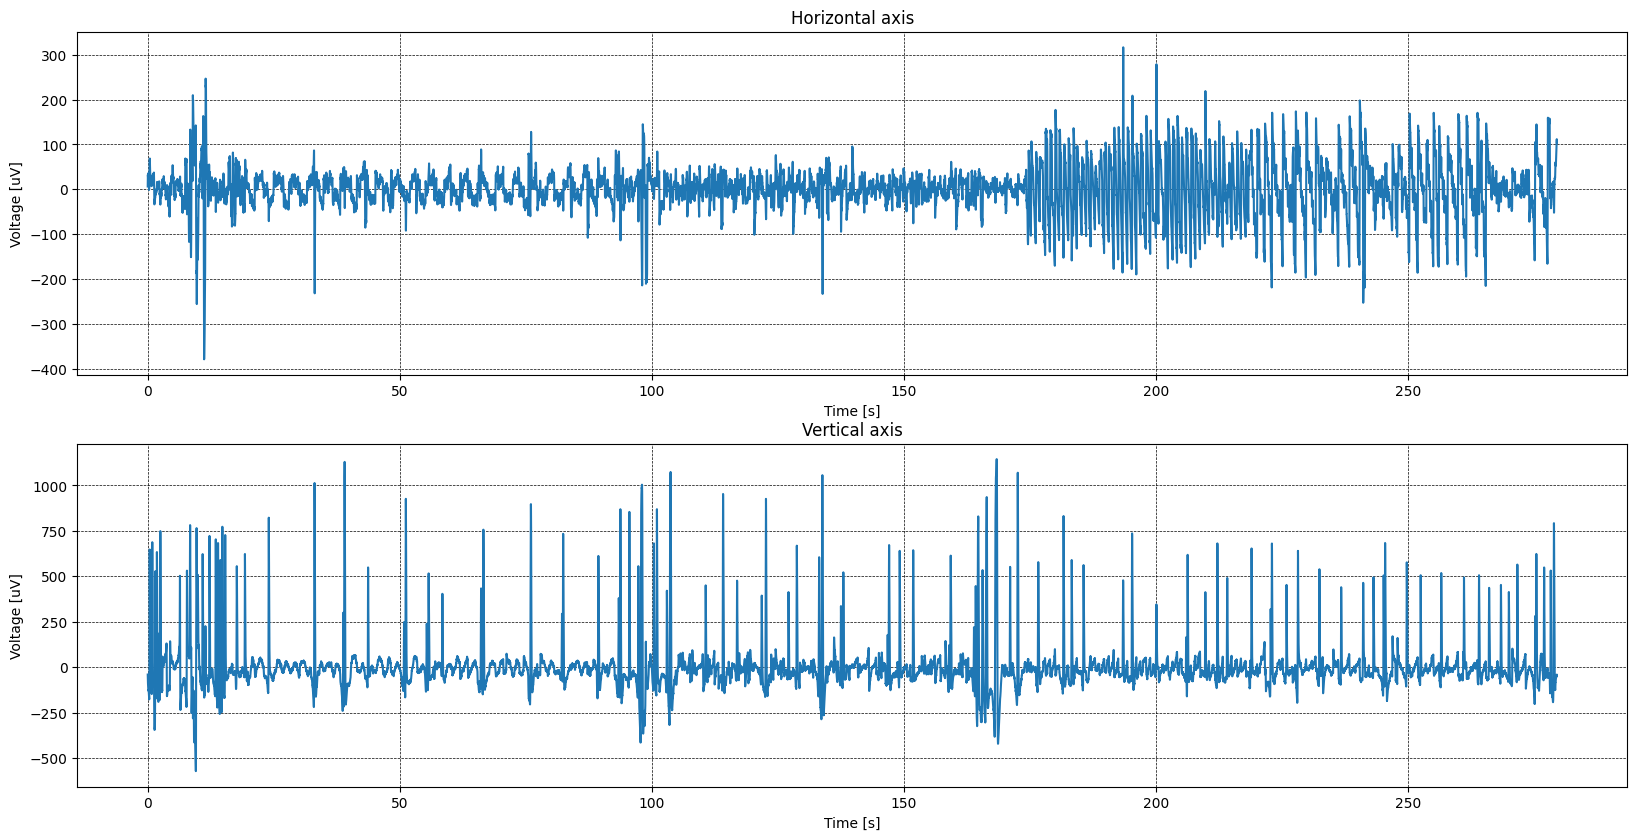

In [ ]:
plt.subplot(2,1,1)
plt.plot(t,filteredH)
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.subplot(2,1,2)
plt.plot(t,filteredV)
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')

Text(0, 0.5, 'Voltage [uV]')

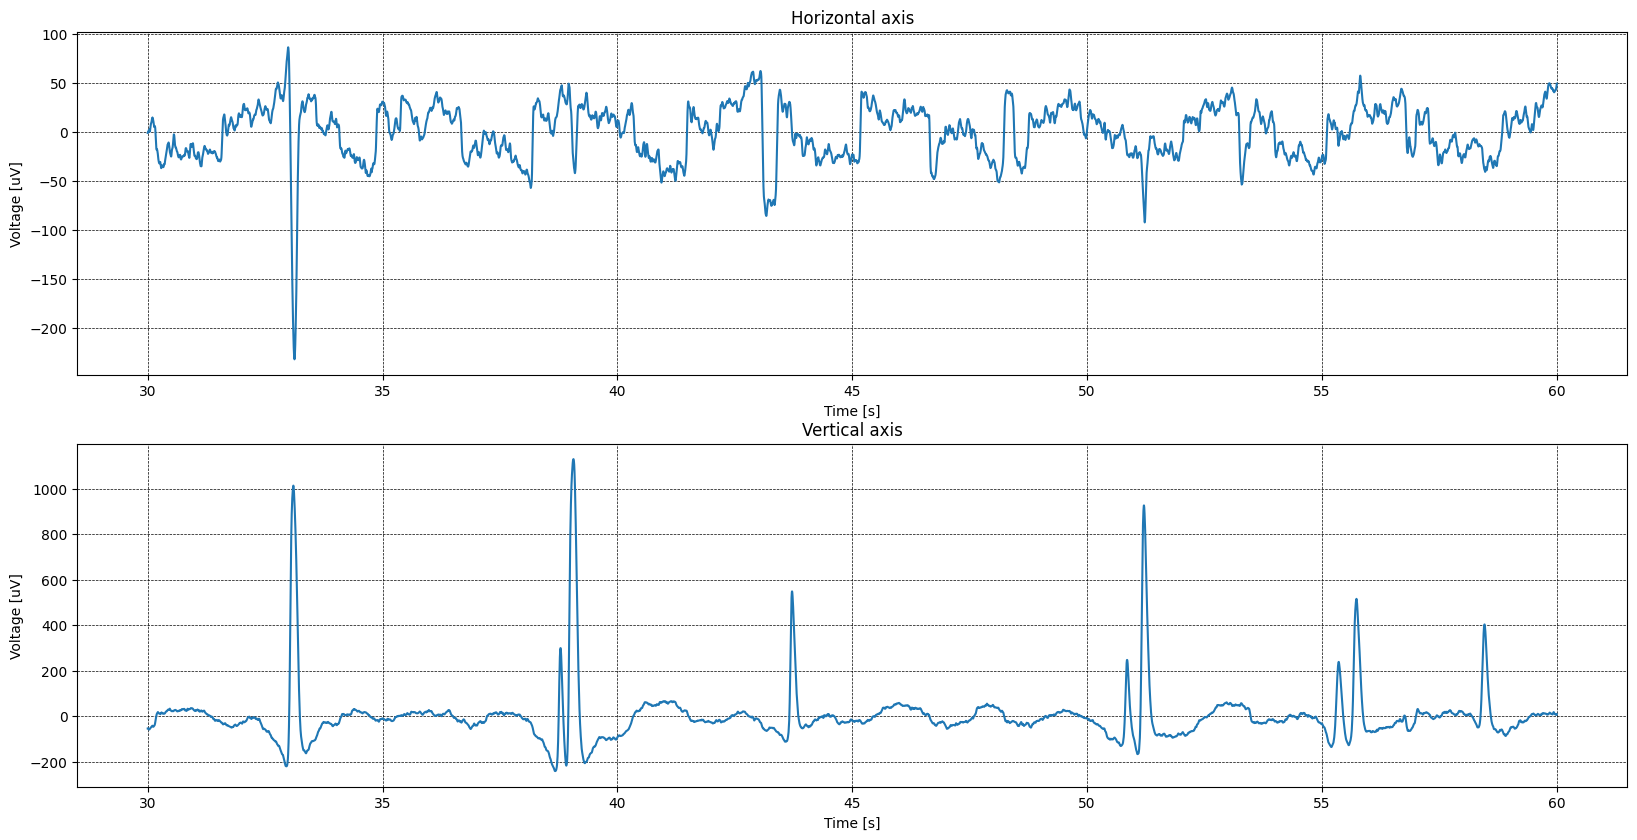

In [ ]:
plt.subplot(2,1,1)
plt.plot(t[30*Fs:60*Fs],filteredH[30*Fs:60*Fs])
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.subplot(2,1,2)
plt.plot(t[30*Fs:60*Fs],filteredV[30*Fs:60*Fs])
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')

Text(0, 0.5, 'Voltage [uV]')

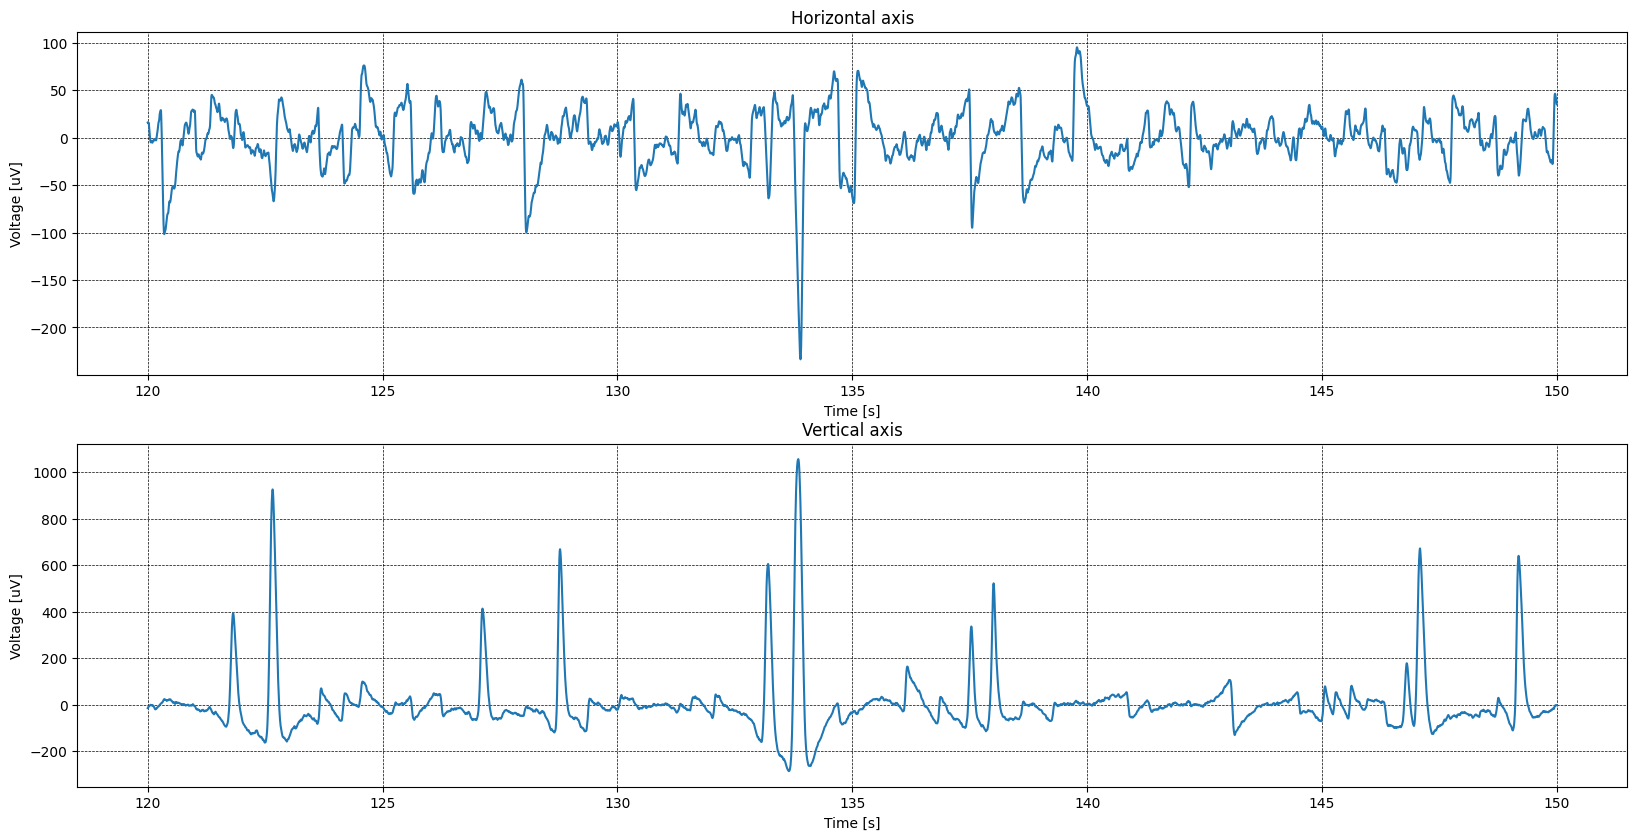

In [ ]:
plt.subplot(2,1,1)
plt.plot(t[120*Fs:150*Fs],filteredH[120*Fs:150*Fs])
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.subplot(2,1,2)
plt.plot(t[120*Fs:150*Fs],filteredV[120*Fs:150*Fs])
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')

Text(0, 0.5, 'Voltage [uV]')

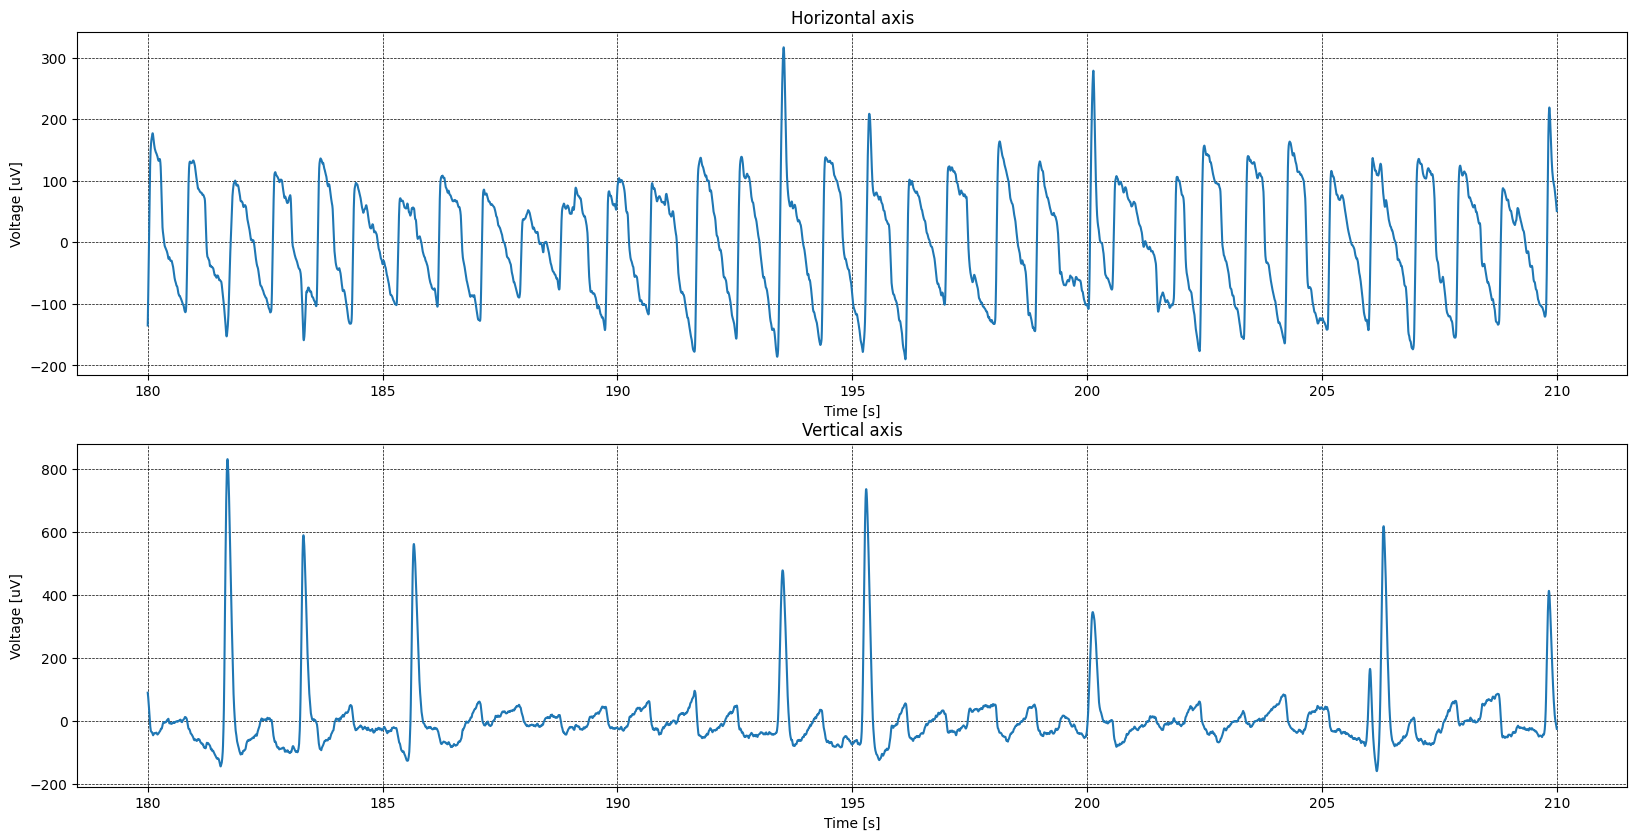

In [ ]:
plt.subplot(2,1,1)
plt.plot(t[180*Fs:210*Fs],filteredH[180*Fs:210*Fs])
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.subplot(2,1,2)
plt.plot(t[180*Fs:210*Fs],filteredV[180*Fs:210*Fs])
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')

Text(0, 0.5, 'Voltage [uV]')

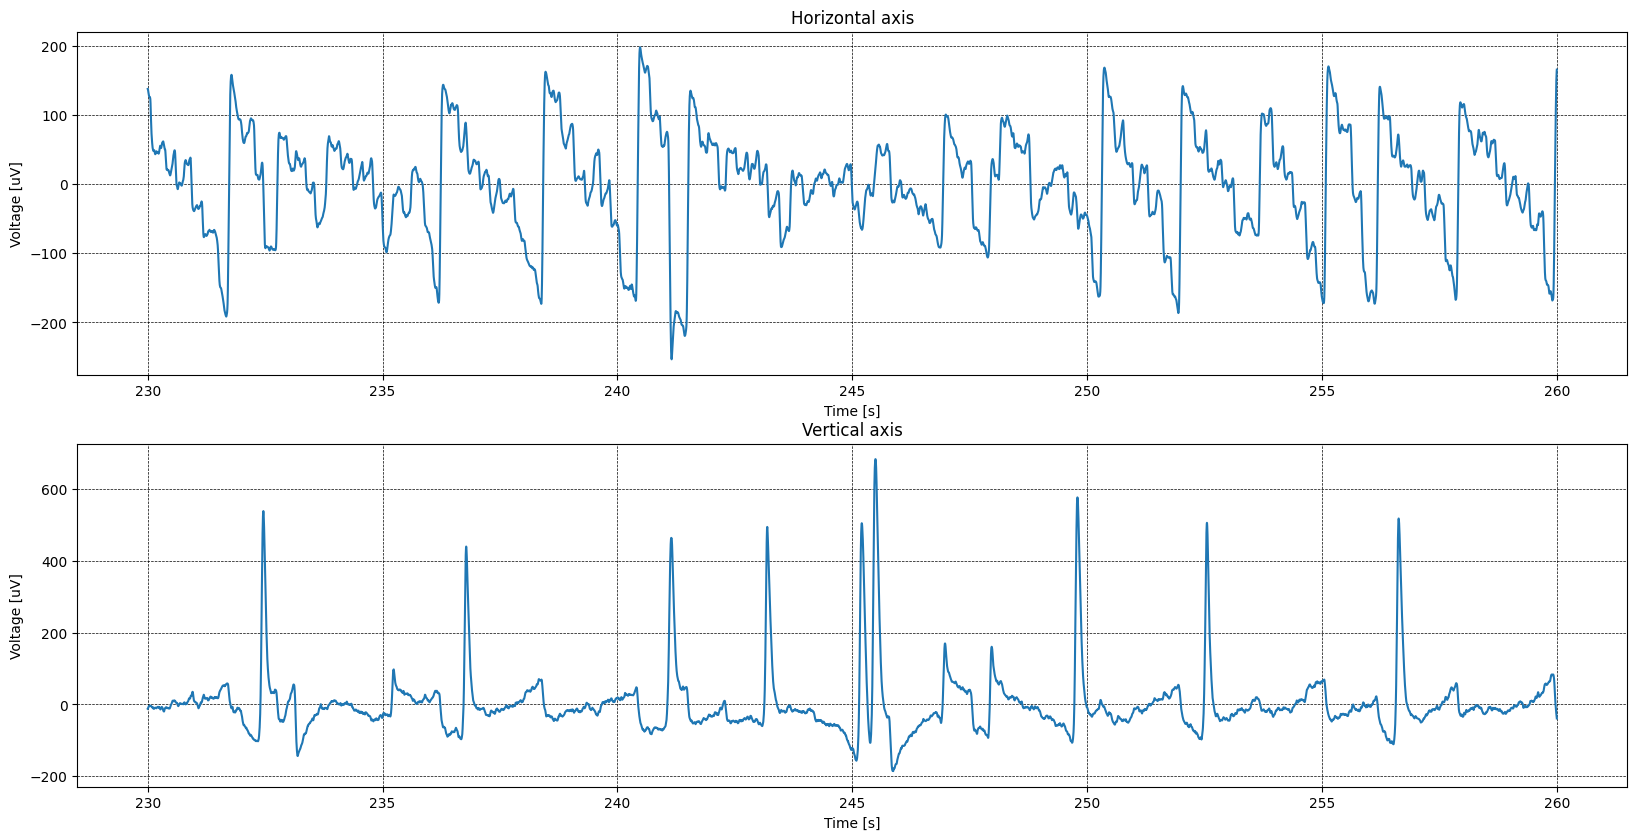

In [ ]:
plt.subplot(2,1,1)
plt.plot(t[230*Fs:260*Fs],filteredH[230*Fs:260*Fs])
plt.title('Horizontal axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')
plt.subplot(2,1,2)
plt.plot(t[230*Fs:260*Fs],filteredV[230*Fs:260*Fs])
plt.title('Vertical axis')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [uV]')